# Topic: Predicting behaviour to retain customers for telco company

### Group Members:

1) Teh Hung Wei (MCS212011) <br>
2) Tan Fei Zhi  (MCS221016) <br>
3) Chong Xian Jun (MCS211047) 

### Dataset used: Dataset-B-TelcoChurn

The Telecom Churn Dataset consists of customer data(features) and develop focuses on customer retention programs, along with a churn label specifying whether a customer canceled the subscription, will be used to develop predictive models. 

### import libraries and data

In [1]:
# import libraries
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# classification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

# processing / transformation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE


from sklearn.cluster import DBSCAN
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data
url = 'https://raw.githubusercontent.com/juxue97/MCSD-Assignment/main/Dataset-B-TelcoChurn.csv'
df = pd.read_csv(url)

df.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

## Part 1: Exploratory Data Analysis (EDA)

- check dimension
- check null
- visualize data

In [3]:
# check dimension
print('df.shape:', df.shape)

df.shape: (2666, 20)


In [4]:
def outlier(df):
    '''
    detect outliers for continuous features
    '''
    continuous_df = df.select_dtypes(include=[float, int])
    Q1 = continuous_df.quantile(0.25)
    Q3 = continuous_df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((continuous_df < (Q1 - 1.5 * IQR)) | (continuous_df > (Q3 + 1.5 * IQR))).sum()
    outliers = outliers.to_frame(name='outliers')

    return outliers


def df_info(input_df):
    """
    retrieve summary info about the data including dtype, number of null values and unique values per column, and summary statistics.
    """
    df = input_df.copy()

    outliers = outlier(df)
    
    # Summary stats for continuous data
    descr = df.describe().T
    
    # Nulls, data types, and unique values
    nulls = df.isnull().sum().to_frame(name='nulls')
    dtypes = df.dtypes.to_frame(name='dtype')
    nuniques = df.nunique().to_frame(name='nunique')
    info = pd.concat([nulls, dtypes, nuniques], axis=1)
    
    # Left join continuous data
    info = info.merge(outliers, left_index=True, right_index=True, how='left')
    info = info.merge(descr, left_index=True, right_index=True, how='left').sort_values('dtype').reset_index()
    info.rename(columns={'index':'features'}, inplace=True)
    return info

df_info(df)

features  nulls    dtype  nunique  outliers   count  \
0                    Churn      0     bool        2       NaN     NaN   
1           Account length      0    int64      205      12.0  2666.0   
2                Area code      0    int64        3       0.0  2666.0   
3         Total intl calls      0    int64       21      66.0  2666.0   
4    Number vmail messages      0    int64       42       2.0  2666.0   
5          Total day calls      0    int64      115      18.0  2666.0   
6   Customer service calls      0    int64       10     210.0  2666.0   
7          Total eve calls      0    int64      120      15.0  2666.0   
8        Total night calls      0    int64      118      19.0  2666.0   
9        Total intl charge      0  float64      158      40.0  2666.0   
10      Total intl minutes      0  float64      158      37.0  2666.0   
11      Total night charge      0  float64      885      22.0  2666.0   
12       Total eve minutes      0  float64     1442      17.0  2666.0   
13        Total eve charge      0  float64     1301      17.0  2666.0   
14        Total day charge      0  float64     1489      21.0  2666.0   
15       Total day minutes      0  float64     1489      21.0  2666.0   
16     Total night minutes      0  float64     1444      22.0  2666.0   
17         Voice mail plan      0   object        2       NaN     NaN   
18      International plan      0   object        2       NaN     NaN   
19                   State      0   object       51       NaN     NaN   

          mean        std     min       25%     50%      75%     max  
0          NaN        NaN     NaN       NaN     NaN      NaN     NaN  
1   100.620405  39.563974    1.00   73.0000  100.00  127.000  243.00  
2   437.438860  42.521018  408.00  408.0000  415.00  510.000  510.00  
3     4.467367   2.456195    0.00    3.0000    4.00    6.000   20.00  
4     8.021755  13.612277    0.00    0.0000    0.00   19.000   50.00  
5   100.310203  19.988162    0.00   87.0000  101.00  114.000  160.00  
6     1.562641   1.311236    0.00    1.0000    1.00    2.000    9.00  
7   100.023631  20.161445    0.00   87.0000  100.00  114.000  170.00  
8   100.106152  19.418459   33.00   87.0000  100.00  113.000  166.00  
9     2.764490   0.752812    0.00    2.3000    2.75    3.270    5.40  
10   10.237022   2.788349    0.00    8.5000   10.20   12.100   20.00  
11    9.052689   2.285120    1.97    7.5125    9.05   10.640   17.77  
12  200.386159  50.951515    0.00  165.3000  200.90  235.100  363.70  
13   17.033072   4.330864    0.00   14.0500   17.08   19.980   30.91  
14   30.512404   9.215733    0.00   24.3800   30.59   36.700   59.64  
15  179.481620  54.210350    0.00  143.4000  179.95  215.900  350.80  
16  201.168942  50.780323   43.70  166.9250  201.15  236.475  395.00  
17         NaN        NaN     NaN       NaN     NaN      NaN     NaN  
18         NaN        NaN     NaN       NaN     NaN      NaN     NaN  
19         NaN        NaN     NaN       NaN     NaN      NaN     NaN

This dataset consists of 2666 data with 20 features. <br> 

Amongst the 20 features, 16 of them are numerical features, 3 of them are categorical features (state,international plan, and voice mail plan), and 1 boolean feaeture (churn). While the `Area code` feature's dtype is `int64`, it has only 3 unique values, indicating that it is more appropriate to be transformed to categorical feature in data preprocessing step. <br>

Besides, there are many outliers for the numerical features, assuming outlier is defined by the Interquartile range (IQR) method. It shows that most of the numerical features have long tailed distribution consisting of a noticeable amount of edge cases. 

In [5]:
# change dtype of `Area code` to string
df['Area code'] = df['Area code'].apply(lambda x: str(x))

In [6]:
# check unique values in all categorical features
def object_review(df):
    for column in df.columns:
        #print(column)
        if (df[column].dtypes == "O"):
            print(column,' :', df[column].unique(), "\n" )

object_review(df)

State  : ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'WV' 'RI' 'IA' 'MT' 'ID' 'VT' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'NE' 'WY' 'IL' 'NH' 'LA' 'GA' 'AK' 'MD' 'AR' 'WI'
 'OR' 'DE' 'IN' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'NY' 'KY'
 'ME' 'MS' 'MI' 'SC' 'TN' 'PA' 'HI' 'ND' 'CT'] 

Area code  : ['415' '408' '510'] 

International plan  : ['No' 'Yes'] 

Voice mail plan  : ['Yes' 'No'] 



- `OneHotEncode` for `State` and `Area code`. The `State` feature consists of many categories, which can result in sparse matrix in the processed dataframe. Thus, dimensionality reduction is needed before conducting the clustering task to reduce its impact. <br>
- `BinaryEncode` for `International plan` and `Voice mail plan`. 
<br>

PS: it is also possible that we can Binary Encode all categorical data, as binary encoding does not result in information loss, and it can also reduce the curse of dimensionality. However, it will result in reduced interpretability.

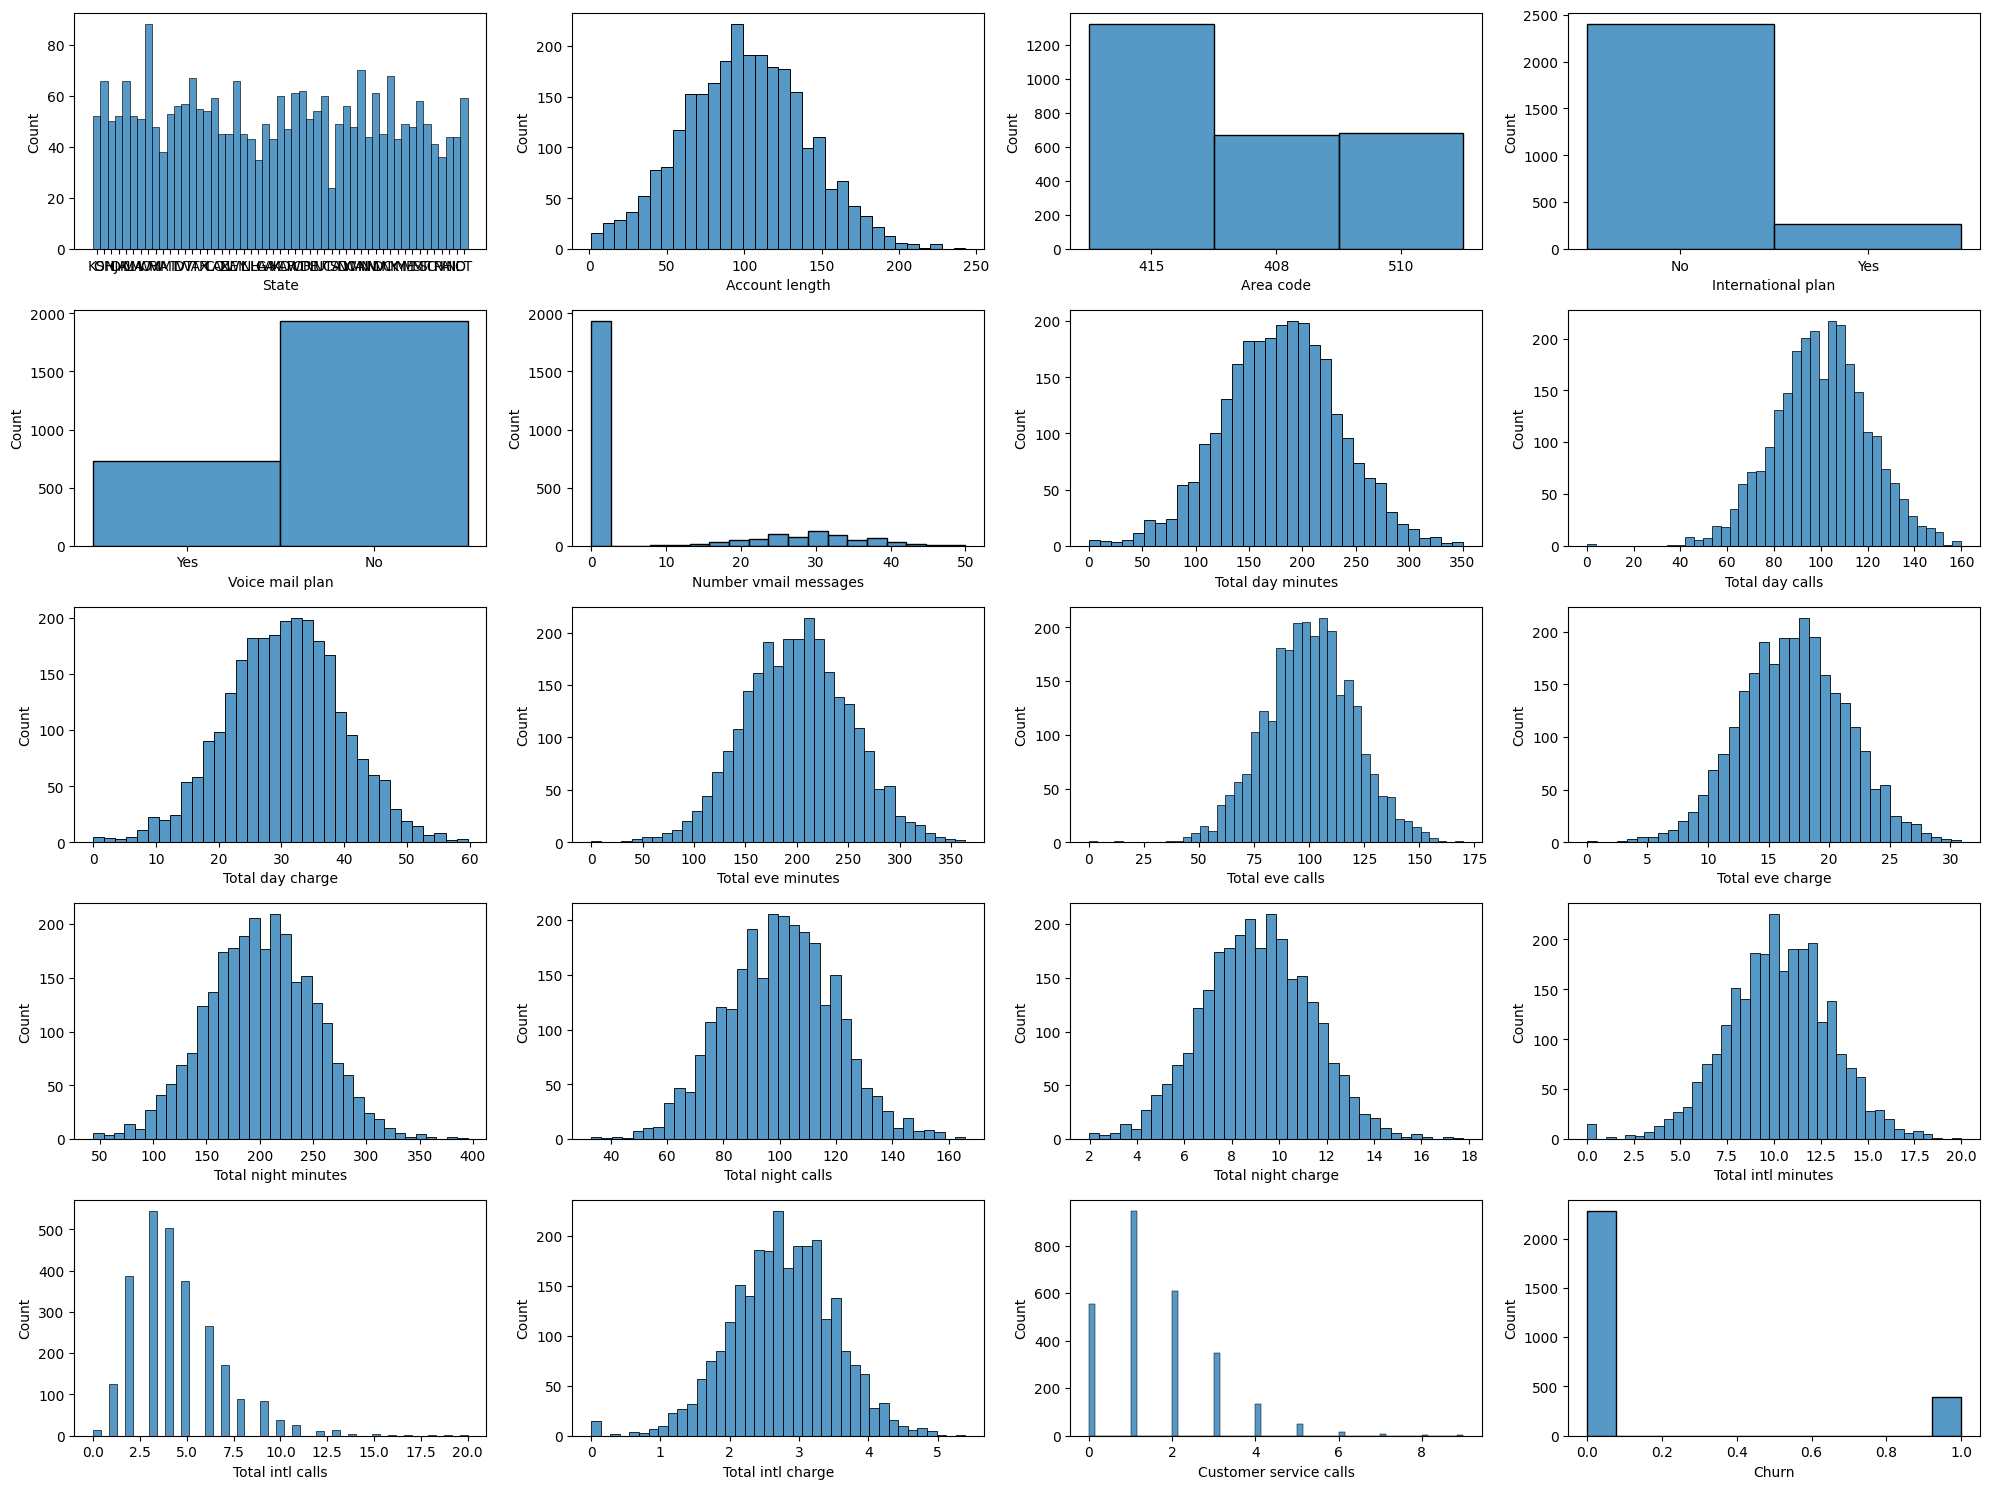

In [7]:
# visualise the distribution of data with histogram

num_rows = (len(df.columns) + 2) // 4  # Calculate the number of rows needed
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20,15))

# Create a histplot for each column in the DataFrame
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axes[i // 4, i % 4])
plt.tight_layout()
plt.show()

All numerical features have mostly normal distribution, which facilitates the use of clustering models such as k-means as k-means assumes the data is spherical and normally distributed. From the graphs, we can also see that there are no strong outliers observed among the numerical features. Thus, the outliers defined by IQR method are viewed as edge cases and preserved instead of being removed.<br>

As for categorical features, most of them have class imbalance to different extent. However, as our task is unsupervised clustering, it does not require treatment such as oversampling and undersampling of target variable commonly used in classification tasks.  

<AxesSubplot: >

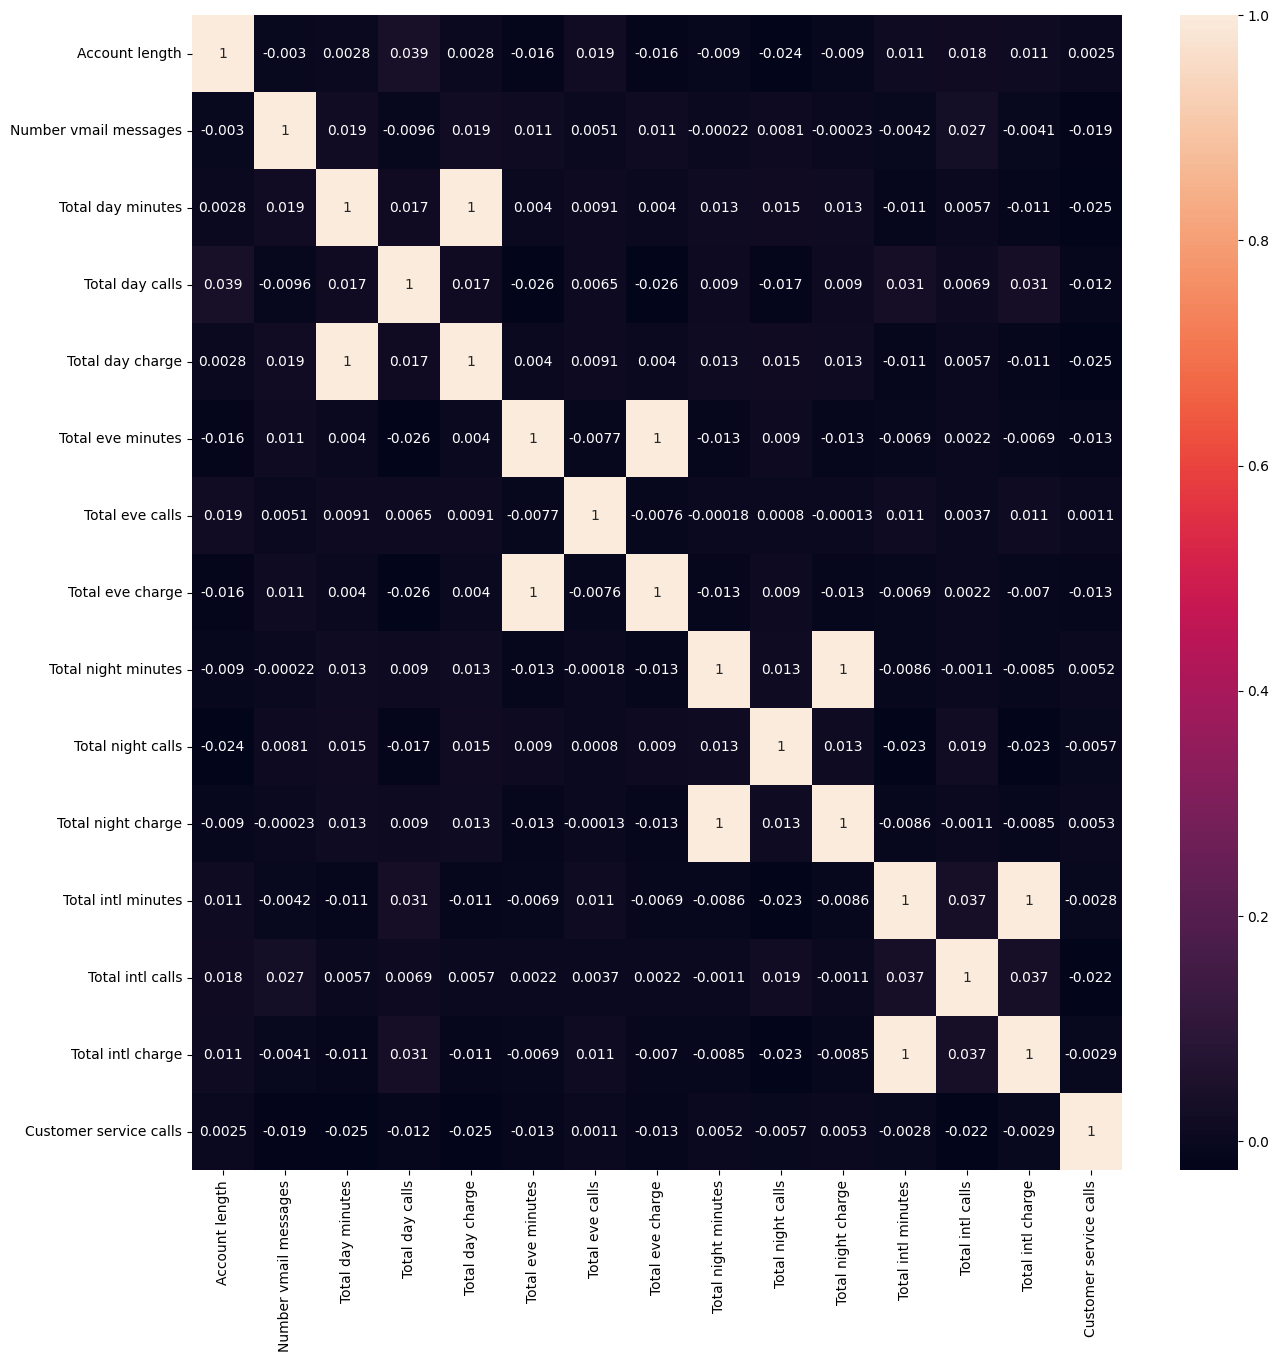

In [8]:
# correlation study
plt.figure(figsize=(15,15)) 
sns.heatmap(df.drop('Churn', axis=1).select_dtypes(exclude='object').corr(), annot=True)

In general, the features within the datasets have very low correlation with one another. However, there are a few features that have correlation coefficient of 1 to one another, which might results in redundancy and multicolinearity. <br>

Highly correlated features: <br>
1. `"Total day charge"` and `"Total day minutes"`
2. `"Total eve charge"` and `"Total eve minutes"`
3. `"Total night charge"` and `"Total night minutes"`
4. `"Total intl charge"` and `"Total intl minutes"`
<br>

The highly correlated features need to be treated. As total charge is calculated from unit charge * time, charge per minute can be extracted to replace total charge. 

False    2278
True      388
Name: Churn, dtype: int64
Churn rate: 14.553638409602401
85.4463615903976


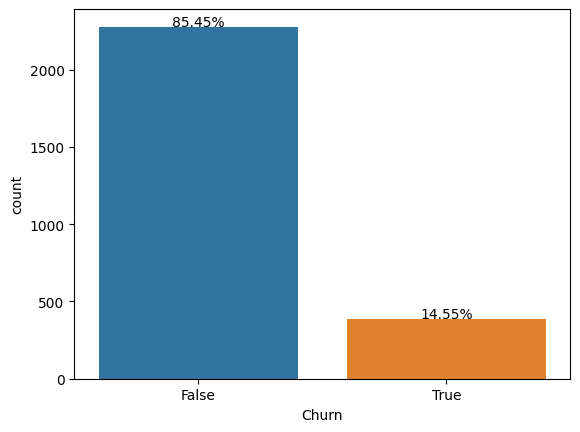

In [10]:
df_class = df.Churn.value_counts() # see what are the classes
percentage_churn = df_class[True]*100/(df_class[False]+df_class[True])

print(df_class)
print('Churn rate:', percentage_churn)
print(100-percentage_churn)
ax = sns.countplot(x=df.Churn)

#ax = sns.countplot(x=df.Churn)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/len(df)),
            ha="center")
plt.show()

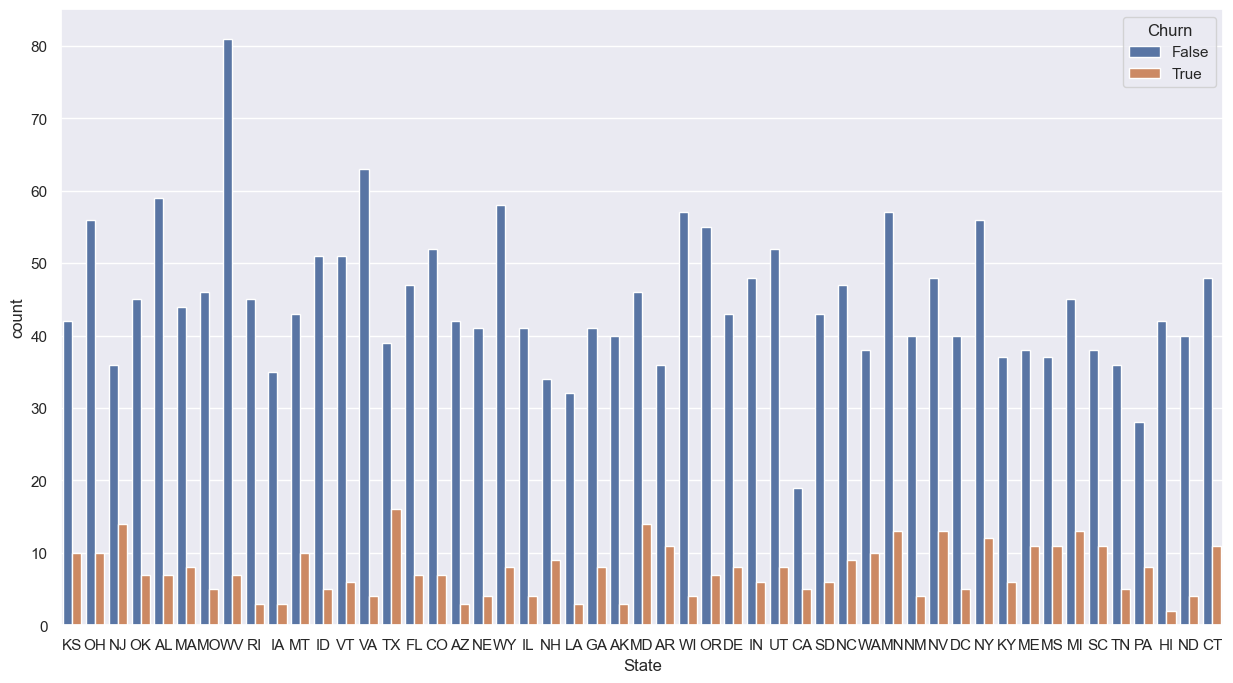

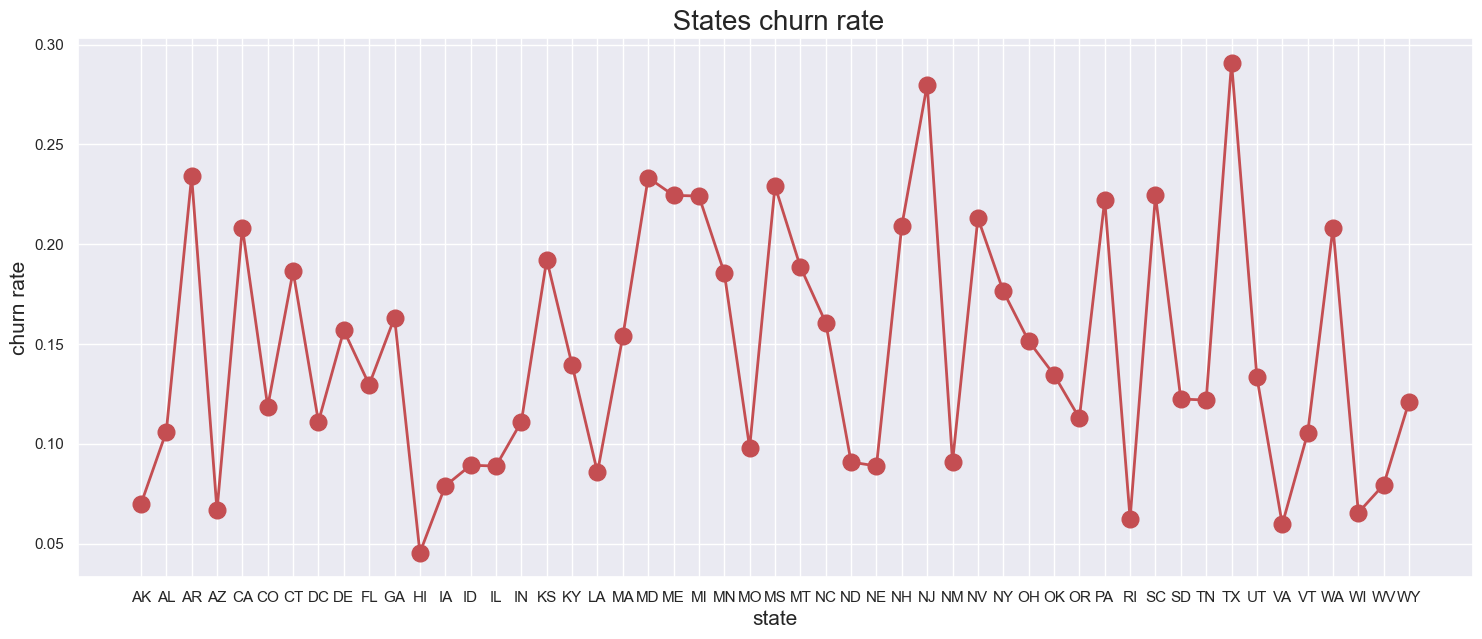

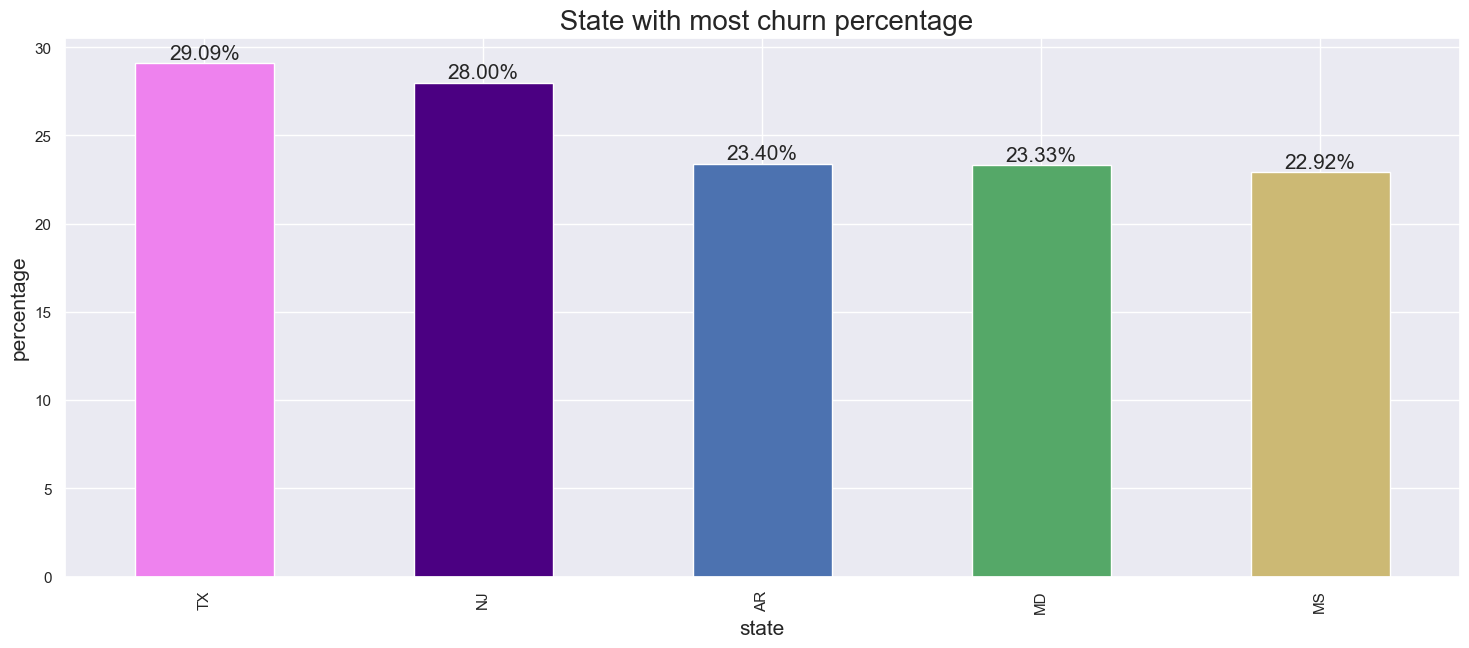

In [ ]:
 # visualize the number of customer according to states
sns.set(style='darkgrid')
plt.figure(figsize=(15,8))
ax = sns.countplot(x='State', hue='Churn',data = df)
plt.show()

#visualize churn rate according to states
#s1=df['State'].unique()
s2=df.groupby(['State'])['Churn'].mean()
s1=s2.index

plt.rcParams['figure.figsize'] = (18, 7)

plt.plot(s1,s2,color='r', marker='o', linewidth=2, markersize=12)

plt.title(" States churn rate", fontsize = 20)
plt.xlabel('state', fontsize = 15)
plt.ylabel('churn rate', fontsize = 15)
plt.show()

#visualize the top 5 highest churn rate states
ax = ((df.groupby(['State'])['Churn'].mean())*100).sort_values(ascending = False).head(5).plot.bar(color = ['violet','indigo','b','g','y'])

for i in range(5):
    height = ((df.groupby(['State'])['Churn'].mean())*100).sort_values(ascending = False).head(5)[i]
    plt.annotate("{:.2f}%".format(height),(i, height), ha="center",va="bottom",fontsize=15)

plt.title(" State with most churn percentage", fontsize = 20)
plt.xlabel('state', fontsize = 15)
plt.ylabel('percentage', fontsize = 15)
plt.show()

Churn      False  True  Percentage_Churn
Area code                               
408          575    94         14.050822
415         1123   195         14.795144
510          580    99         14.580265
[1123, 575, 580, 195, 94, 99]


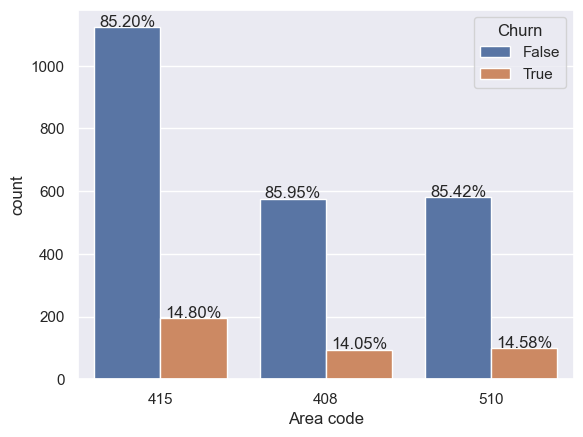

In [11]:
#Analyze area code vs churn
Area_code_data = pd.crosstab(df["Area code"],df["Churn"])
Area_code_data['Percentage_Churn'] = Area_code_data.apply(lambda x : x[True]*100/(x[False]+x[True]),axis = 1)
print(Area_code_data)

#visualize using bar chart
sns.set(style="darkgrid")
ax = sns.countplot(x="Area code", hue="Churn", data = df)

y = [Area_code_data[0][1],Area_code_data[0][0],Area_code_data[0][2],
    Area_code_data[1][1],Area_code_data[1][0],Area_code_data[1][2]]

print (y)
for k,p in enumerate(ax.patches):
    height = p.get_height()
    if(k<3):
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height / (y[k]+y[k+3])),
                ha="center")
    if(k>=3):
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height / (y[k]+y[k-3])),
                ha="center")
# GET THE WIDTH LABEL
plt.show()

In [12]:
# Analyze "International Plan"
ip = pd.crosstab(df["International plan"],df["Churn"])
ip["Percentage Churn"] = ip.apply(lambda x : x[1]*100/(x[0]+x[1]),axis = 1)
print(ip)


# Visualize with graph
ax = sns.countplot(x="International plan",hue="Churn", data= df)
j=0
arr=[]
for k,p in enumerate(ax.patches):
    i=0
    height = p.get_height()
    if (k<2):
        percent = 100*height / (ip[i][k]+ip[i+1][k])
        arr.append(percent)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(percent),
                ha="center")
    if (k>=2):
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100-arr[j]),
                ha="center")
        j+=1
plt.show()

KeyError: 1

Churn            False  True  Percentage Churn
Voice mail plan                               
No                1610   323         16.709778
Yes                668    65          8.867667


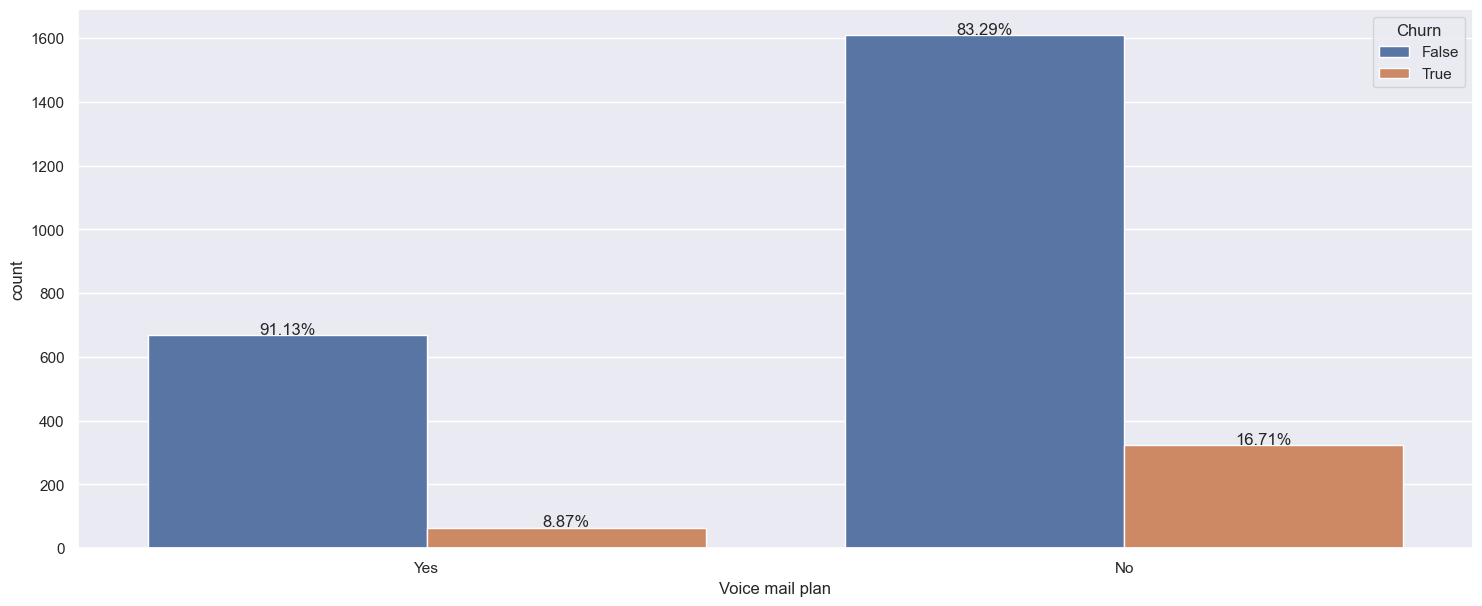

In [13]:
#Analyze Voice Mail Plan

vmp = pd.crosstab(df["Voice mail plan"],df["Churn"])
vmp["Percentage Churn"] = vmp.apply(lambda x : x[1]*100/(x[0]+x[1]),axis = 1)
print(vmp)

y = [vmp[0][1],vmp[0][0],vmp[1][1],vmp[1][0]]

# Visualize with graph
ax = sns.countplot(x="Voice mail plan",hue="Churn", data= df)
i=0
for k,p in enumerate(ax.patches):

    height = p.get_height()
    if(k<=1):
        #print(y[i],y[i+2])
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height / (y[i]+y[i+2])),
                ha="center")
        i+=1
    if(k>1):
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height / (y[i]+y[i-2])),
                ha="center")
        i+=1
plt.show()

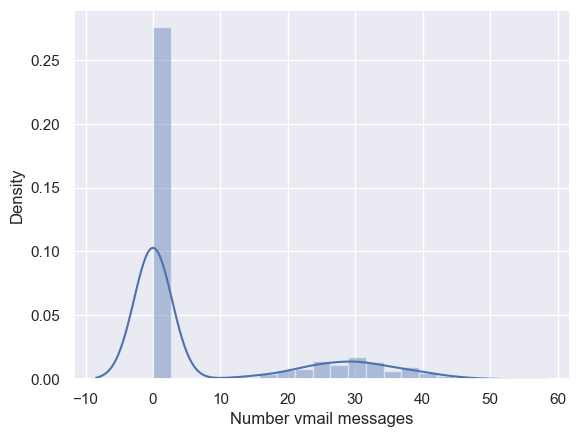

<Figure size 1000x800 with 0 Axes>

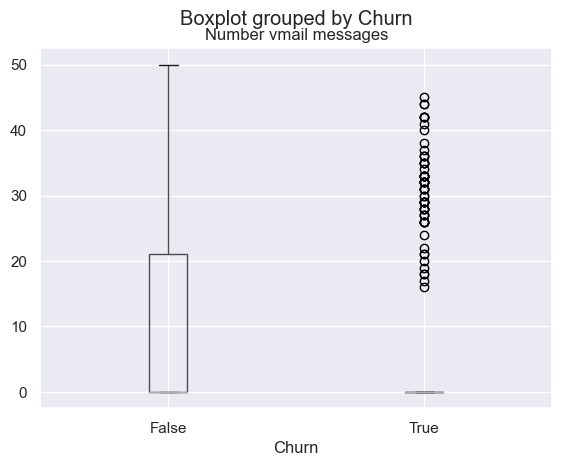

In [13]:
#Analyze Number vmail messages

# Visualize with graph
sns.distplot(df["Number vmail messages"])

#Analyse the yes region (>0)
fig =  plt.figure(figsize = (10,8))
df.boxplot(column="Number vmail messages", by="Churn")
fig.suptitle('Number vmail message', fontsize=14, fontweight='bold')
plt.show()

Churn                   False  True  Percentage Churn
Customer service calls                               
0                         476    79         14.234234
1                         846    99         10.476190
2                         546    62         10.197368
3                         311    37         10.632184
4                          69    64         48.120301
5                          20    29         59.183673
6                           7    10         58.823529
7                           3     5         62.500000
8                           0     1        100.000000
9                           0     2        100.000000


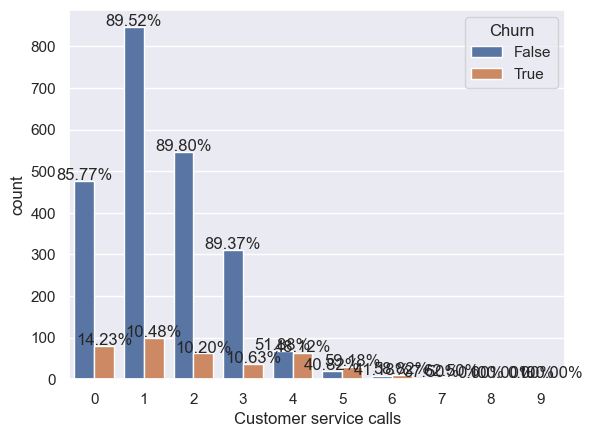

In [15]:
#Analyze Customer service calls

csc = pd.crosstab(df["Customer service calls"],df["Churn"])
csc["Percentage Churn"] = csc.apply(lambda x : x[True]*100/(x[False]+x[True]),axis = 1)
print(csc)


# Visualize with graph
ax = sns.countplot(x='Customer service calls', hue="Churn",data=df)

for k,p in enumerate(ax.patches):
    i=0
    height = p.get_height()
    if(k>9):
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height / (csc.loc[int(k-10)][i]+csc.loc[int(k-10)][i+1])),
                ha="center")
        continue

    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height / (csc.loc[int(k)][i]+ csc.loc[int(k)][i+1])),
            ha="center")
    


plt.show()

## Part 2: Data Preparation

- Format data type.
- Perform feature engineering.
- Feature scaling to standardise numerical features.
<br>

Note: As different clustering algorithm has different requirements on data representation, data encoding will be conducted at each clustering stage. 

In [16]:
# change data type of `Area code` to string, 'Churn' to category
df['Area code'] = df['Area code'].apply(lambda x: str(x))
df['Churn'] = df['Churn'].astype(int)

As the clustering analysis is conducted with respect to the churn of teleco service, feature engineering process is carried out with two objectives: 

1. Reduce redundant features in the dataset to prevent the curse of dimensionality when doing clustering analysis. 
2. Ensure that the engineered features are useful predictors of whether a client will churn. 

This can be checked by fitting the engineered dataset into a classifier and retrieving its feature importance. 

In [17]:
cols_dict = {'calls': [i for i in df.columns if 'calls' in i and 'Total' in i and 'intl' not in i]
                 , 'minutes': [i for i in df.columns if 'minutes' in i and 'intl' not in i]
                 , 'charge': [i for i in df.columns if 'charge' in i and 'intl' not in i]
                }

cols_dict

{'calls': ['Total day calls', 'Total eve calls', 'Total night calls'],
 'minutes': ['Total day minutes', 'Total eve minutes', 'Total night minutes'],
 'charge': ['Total day charge', 'Total eve charge', 'Total night charge']}

In [18]:
# extract and filter features in dataset
def feature_engineering(df_in):

    df = df_in.copy()
    
    # extract unit charge
    df['unit fees local'] = df['Total day charge'] / df['Total day minutes'] #local telecom service charge is constant throughout the day
    df['unit fees intl'] = df['Total intl charge'] / df['Total intl minutes'] # international charge is distinct from local charge
    
    # sums up total local calls, minutes and charge
    cols_dict = {'calls': [i for i in df.columns if 'calls' in i and 'Total' in i and 'intl' not in i]
                 , 'minutes': [i for i in df.columns if 'minutes' in i and 'intl' not in i]
                 , 'charge': [i for i in df.columns if 'charge' in i and 'intl' not in i]
                }
    
    for k, v in cols_dict.items():
        sums = df[v].sum(axis=1)
        df[f'local_{k}_total'] = sums

    
    # drop irrelevant columns   
    flat_list = [item for key, value in cols_dict.items() for item in value]
    df.drop(flat_list, axis = 1, inplace=True)
    df.drop(['Account length', 'Area code'], axis = 1, inplace=True)

    return df

df2 = feature_engineering(df)
print(df2.shape)
df2.head()

(2666, 14)


State International plan Voice mail plan  Number vmail messages  \
0    KS                 No             Yes                     25   
1    OH                 No             Yes                     26   
2    NJ                 No              No                      0   
3    OH                Yes              No                      0   
4    OK                Yes              No                      0   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  unit fees local  unit fees intl  \
0                       1      0         0.170011        0.270000   
1                       1      0         0.169988        0.270073   
2                       0      0         0.170008        0.269672   
3                       2      0         0.170007        0.269697   
4                       3      0         0.170006        0.270297   

   local_calls_total  local_minutes_total  local_charge_total  
0                300                707.2               72.86  
1                329                611.5               55.54  
2                328                527.2               59.00  
3                248                558.2               65.02  
4                356                501.9               49.36

In [19]:
# set up classifier to test the engineered dataset

# encode the categorical features
def label_encode(df_in):

    df = df_in.copy()

    for col in df.select_dtypes('object').columns:
        lbl = LabelEncoder()
        df.loc[:, col] = lbl.fit_transform(df.loc[:, col])

    return df

df_enc = label_encode(df)
df2_enc = label_encode(df2)


baseline F1-score: 0.8127845436056559 
F1-score (feature engineered): 0.8955737075350252


<AxesSubplot: >

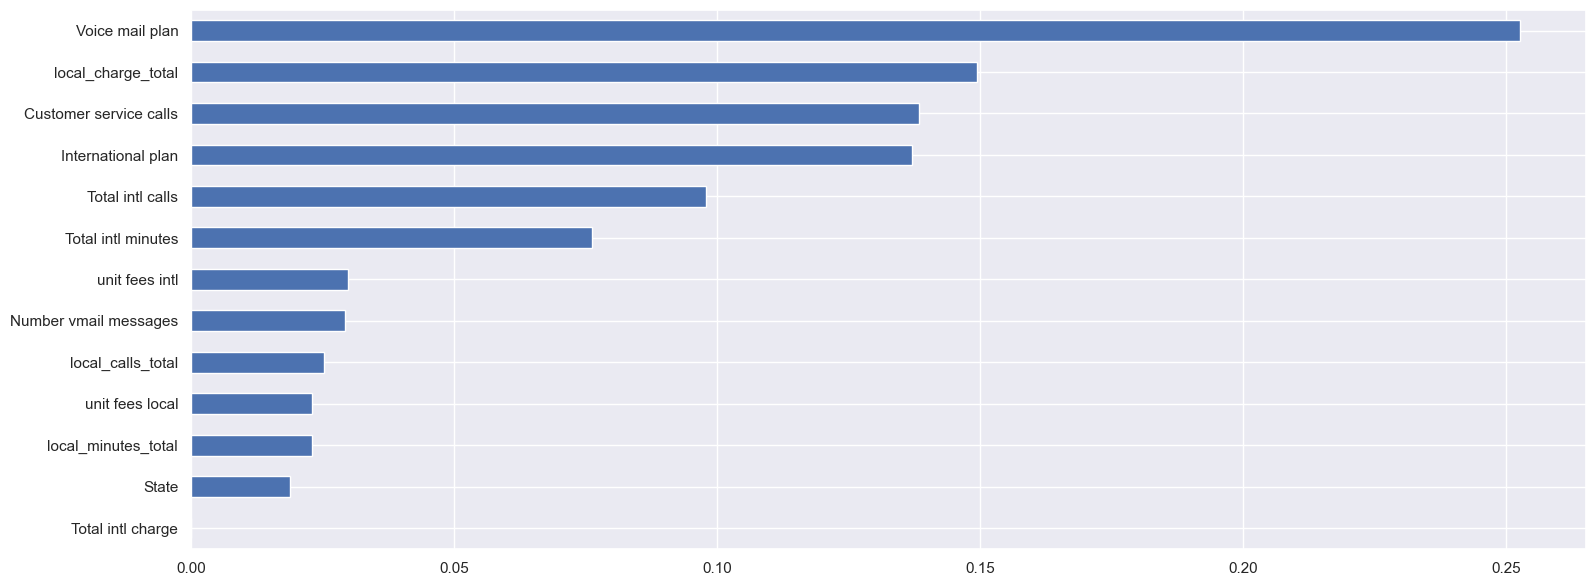

In [20]:
# use xgboost classifier (high accuracy and versatile)
xg = xgb.XGBClassifier()
def classify(df_in, clf):

    '''
    classify and get feature importance
    '''
    X_full = df_in.drop(['Churn'], axis=1)
    y_full = df_in.Churn

    # get roc-auc score to validify the use of this existing set of features
    clf.fit(X_full, y_full)
    roc_auc = cross_val_score(clf, X_full, y_full, scoring = "f1", cv=5).mean() # f1 is used as metric due to class imbalace

    # extract feature importance
    coef = pd.Series(clf.feature_importances_, index = X_full.columns).sort_values(ascending=False)

    return roc_auc, coef


# compare f1 score of baseline df and engineered df
df_score, coef = classify(df_enc, xg)
df2_score, coef2 = classify(df2_enc, xg)


print('baseline F1-score:', df_score, '\nF1-score (feature engineered):', df2_score)
coef2.sort_values(ascending=True).plot(kind='barh')

**classification evaluation**
The cross-validated F1-score for feature engineered data has a very high value of `0.895` compared with the baseline of `0.812`. The feature engineered data `df2` is considered to be a good set of predictors to predict the churn status of a service and is used for clustering analysis. 
<br>


In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
def numerical_feature_scaling(df_in):

    # only apply feature scaling for numerical features
    df = df_in.select_dtypes(include=(np.number))

    scaler = MinMaxScaler()
    num_feat_scaled = scaler.fit_transform(df)
    
    num_df_scaled = pd.DataFrame(num_feat_scaled, columns = df.columns)
    df_scaled = pd.concat([df_in.select_dtypes(include=['object','category']), num_df_scaled], axis=1)

    return df_scaled


df_scaled = numerical_feature_scaling(df2)
df_scaled

State International plan Voice mail plan  Number vmail messages  \
0       KS                 No             Yes                   0.50   
1       OH                 No             Yes                   0.52   
2       NJ                 No              No                   0.00   
3       OH                Yes              No                   0.00   
4       OK                Yes              No                   0.00   
...    ...                ...             ...                    ...   
2661    SC                 No              No                   0.00   
2662    AZ                 No             Yes                   0.72   
2663    WV                 No              No                   0.00   
2664    RI                 No              No                   0.00   
2665    TN                 No             Yes                   0.50   

      Total intl minutes  Total intl calls  Total intl charge  \
0                  0.500              0.15           0.500000   
1                  0.685              0.15           0.685185   
2                  0.610              0.25           0.609259   
3                  0.330              0.35           0.329630   
4                  0.505              0.15           0.505556   
...                  ...               ...                ...   
2661               0.590              0.25           0.590741   
2662               0.495              0.30           0.494444   
2663               0.480              0.20           0.479630   
2664               0.705              0.30           0.705556   
2665               0.685              0.20           0.685185   

      Customer service calls  Churn  unit fees local  unit fees intl  \
0                   0.111111    0.0         0.608827        0.400000   
1                   0.111111    0.0         0.590347        0.416058   
2                   0.000000    0.0         0.606409        0.327869   
3                   0.222222    0.0         0.605210        0.333333   
4                   0.333333    0.0         0.604679        0.465347   
...                      ...    ...              ...             ...   
2661                0.222222    0.0         0.605791        0.474576   
2662                0.222222    0.0         0.580026        0.333333   
2663                0.333333    0.0         0.610125        0.354167   
2664                0.222222    0.0         0.617257        0.446809   
2665                0.000000    0.0         0.606655        0.416058   

      local_calls_total  local_minutes_total  local_charge_total  
0              0.504505             0.724225            0.728575  
1              0.635135             0.563789            0.489942  
2              0.630631             0.422464            0.537614  
3              0.270270             0.474434            0.620557  
4              0.756757             0.380050            0.404795  
...                 ...                  ...                 ...  
2661           0.477477             0.453646            0.399559  
2662           0.441441             0.629673            0.515982  
2663           0.211712             0.503940            0.564343  
2664           0.315315             0.647611            0.605539  
2665           0.378378             0.782062            0.734775  

[2666 rows x 14 columns]

In [23]:
df_scaled.isnull().sum()

State                      0
International plan         0
Voice mail plan            0
Number vmail messages      0
Total intl minutes         0
Total intl calls           0
Total intl charge          0
Customer service calls     0
Churn                      0
unit fees local            2
unit fees intl            15
local_calls_total          0
local_minutes_total        0
local_charge_total         0
dtype: int64

In [24]:
df_scaled['unit fees local'].fillna(df_scaled['unit fees local'].mean(), inplace=True)
df_scaled['unit fees intl'].fillna(df_scaled['unit fees intl'].mean(), inplace=True)

## Part 3: Clustering

2 types of clustering algorithms are used. <br>

1. Partition based clustering: `k-prototype` model <br>
As the data consists of a mixture of categorical data and numerical data, typical `kmeans` cannot be applied effectively as it is based on Euclidean distance. `kprototype` is a hybrid approach consisting `kmode` to deal with categorical data and `kmeans` for numerical data. <br>

2. Density based clustering: `DBSCAN` model.

## Method 1: K-prototype

This is a clustering model which includes a combination of k-means and k-modes models to achieve clustering of data points around certain prototypes (similar concept as centroids). It calculates Euclidean distances for numerical variables and Similarities for categorical variables and uses an assumed gamma as weightage (which decides the preference towards categorical or numerical variables), to assign points to a cluster. This is iteratively done by re-assigning points to the right clusters each time and stops when the desired number of moves or iterations has been achieved (Huang, 1997).

Gamma is guided by the average standard deviation of the numeric attributes. In cases where gamma is not specified (from domain knowledge), it is automatically calculated from the data. In our model, the parameter value of gamma was found to be 0.15 (which gave somewhat distinct clusters) after iteration using fractions of sigma, which is the standard deviation of the chosen numerical variables. Smaller values (closer to 0) of gamma favour the numerical variables while those larger favour (away from 0) the categorical variables (Huang, 1997).
<br>

reference: https://www.kaggle.com/code/rohanadagouda/unsupervised-learning-using-k-prototype-and-dbscan#Data-Modelling

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 7
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3


Text(0.5, 1.0, 'Determine the number of cluster based on cost function')

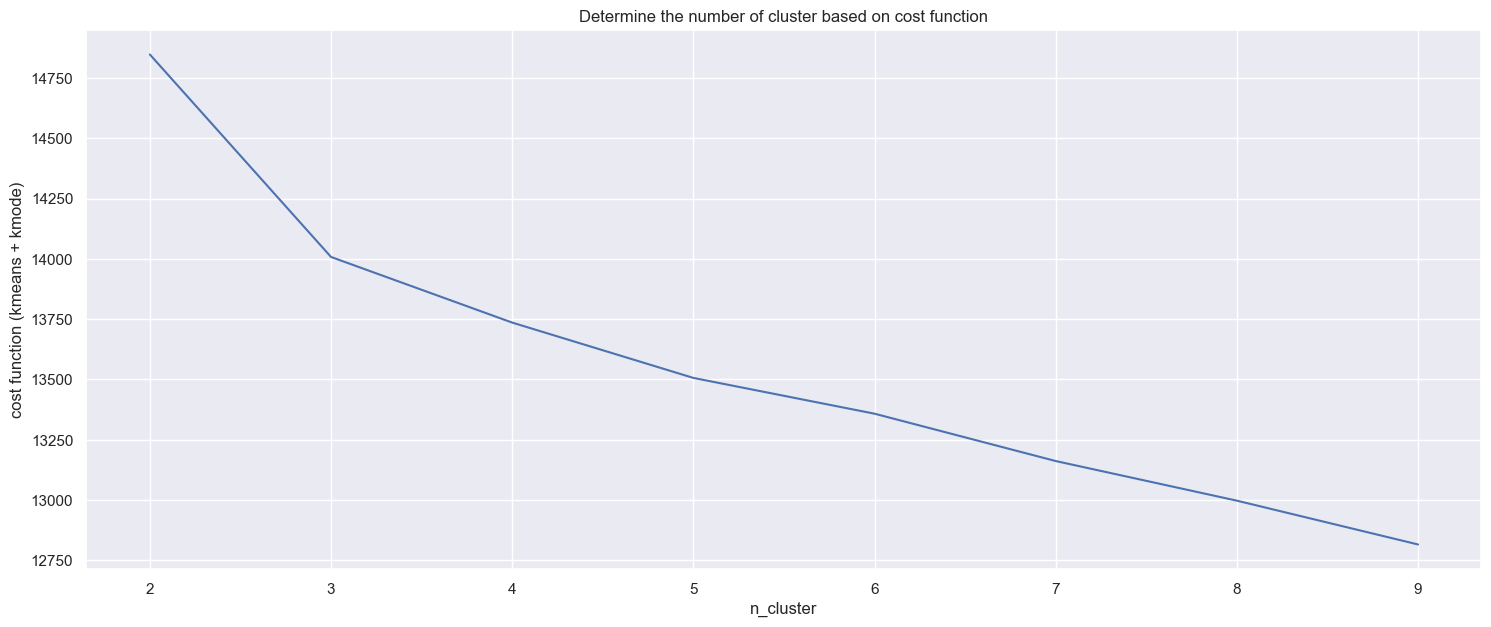

In [25]:
categorical_features_idx = [0, 1, 2, 3]

#Choosing optimal K
cost = []
db_score = []
for num_clusters in list(range(2,10)):
    kproto = KPrototypes(n_clusters=num_clusters, verbose=2, max_iter=10, gamma=4, n_jobs=-1)
    kproto.fit(df_scaled, categorical=categorical_features_idx)
    cost.append(kproto.cost_)

# plot cost function over different number of clusters
plt.plot(list(range(2,10)), cost)
plt.xlabel('n_cluster')
plt.ylabel('cost function (kmeans + kmode)')
plt.title('Determine the number of cluster based on cost function')


Heuristically, the data should be segregated into 3 clusters based on the elbow method. 
<br>

PS: In order to better decide the optimal k for kprototype clustering, `n_clusters` of 3 and 4 are both used to cluster the dataset and visualised to cross validate whether 3 clusters is good enough to cluster the data.  

In [26]:
# Cluster Centroids
def kprototype_cluster(df_in, cluster):
    categorical_features_idx = [0, 1, 2, 3]

    kproto_pred = KPrototypes(n_clusters=cluster, verbose=0, max_iter=10, gamma=4, n_jobs=-1,random_state=50)
    kproto_cluster = kproto_pred.fit_predict(df_in, categorical=categorical_features_idx)

    # add cluster prediction to df_scaled
    kproto_df = pd.concat([df_in, pd.DataFrame(kproto_cluster, columns=['cluster'])], axis=1)
    
    kproto_centroids = kproto_pred.cluster_centroids_
    return kproto_df, kproto_centroids

kproto_n3, centroids_n3 = kprototype_cluster(df_scaled, 3)
kproto_n4, centroids_n4 = kprototype_cluster(df_scaled, 4)

Visually assess the distribution of cluster with:

1. dimensionality reduction
2. visualise plot

In [27]:
def reduce_dim(df_in):
    # create an instance of the t-SNE model to reduce dimension of data
    # from trial and error, it was realised that 2 components cannot capture the cluster distribution well,
    # so, set n_components = 3
    tsne = TSNE(n_components=3)

    # fit the t-SNE model to the data (one-hot encoded)
    X_tsne = tsne.fit_transform(pd.get_dummies(df_in))

    return X_tsne

X_tsne_n3 = reduce_dim(kproto_n3)
X_tsne_n4 = reduce_dim(kproto_n4)

In [28]:
def visualize_cluster_distribution(X_tsne_in, kproto_df_, elev, azim, n_cluster):

    # plot the results
    x = X_tsne_in[:, 0]
    y = X_tsne_in[:, 1]
    z = X_tsne_in[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    # Plot the data
    ax.scatter3D(x, y, z, c= kproto_df_['cluster'], cmap='viridis')

    # Set the elevation and azimuth angles
    ax.view_init(elev=30, azim=60)
    ax.set_title(f't-SNE reduced data with {n_cluster} clusters')

    # Show the plot
    plt.show()

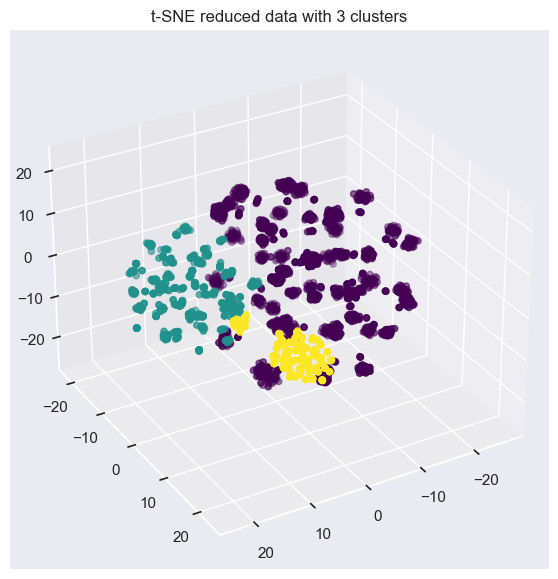

In [29]:
#visualise t-SNE reduced data with 3 clusters
visualize_cluster_distribution(X_tsne_n3, kproto_n3, 30, 60, 3)

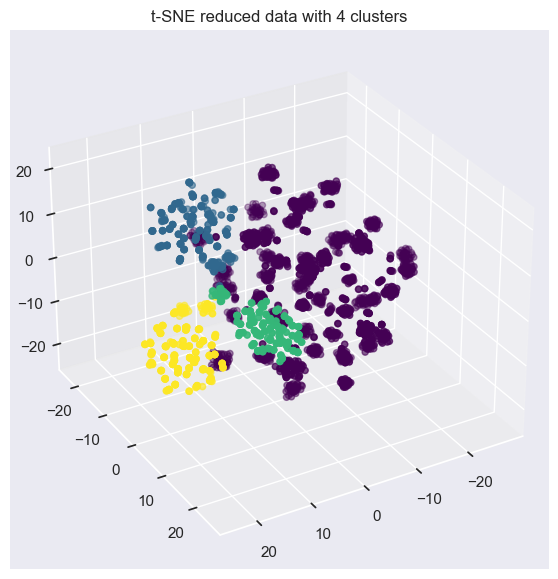

In [30]:
#visualise t-SNE reduced data with 4 clusters
visualize_cluster_distribution(X_tsne_n4, kproto_n4, 30, 0, 4)

It appears that `n_cluster` of 3 is able to cluster the data succintly based on elbow method and visualisation. 

In [31]:
# concat the cluster results to df2 before analysis
df_c1 = pd.concat([df2, kproto_n3['cluster']], axis=1)
df_c1

State International plan Voice mail plan  Number vmail messages  \
0       KS                 No             Yes                     25   
1       OH                 No             Yes                     26   
2       NJ                 No              No                      0   
3       OH                Yes              No                      0   
4       OK                Yes              No                      0   
...    ...                ...             ...                    ...   
2661    SC                 No              No                      0   
2662    AZ                 No             Yes                     36   
2663    WV                 No              No                      0   
2664    RI                 No              No                      0   
2665    TN                 No             Yes                     25   

      Total intl minutes  Total intl calls  Total intl charge  \
0                   10.0                 3               2.70   
1                   13.7                 3               3.70   
2                   12.2                 5               3.29   
3                    6.6                 7               1.78   
4                   10.1                 3               2.73   
...                  ...               ...                ...   
2661                11.8                 5               3.19   
2662                 9.9                 6               2.67   
2663                 9.6                 4               2.59   
2664                14.1                 6               3.81   
2665                13.7                 4               3.70   

      Customer service calls  Churn  unit fees local  unit fees intl  \
0                          1      0         0.170011        0.270000   
1                          1      0         0.169988        0.270073   
2                          0      0         0.170008        0.269672   
3                          2      0         0.170007        0.269697   
4                          3      0         0.170006        0.270297   
...                      ...    ...              ...             ...   
2661                       2      0         0.170007        0.270339   
2662                       2      0         0.169974        0.269697   
2663                       3      0         0.170013        0.269792   
2664                       2      0         0.170022        0.270213   
2665                       0      0         0.170009        0.270073   

      local_calls_total  local_minutes_total  local_charge_total  cluster  
0                   300                707.2               72.86        1  
1                   329                611.5               55.54        1  
2                   328                527.2               59.00        0  
3                   248                558.2               65.02        2  
4                   356                501.9               49.36        2  
...                 ...                  ...                 ...      ...  
2661                294                545.8               48.98        0  
2662                286                650.8               57.43        1  
2663                235                575.8               60.94        0  
2664                258                661.5               63.93        0  
2665                272                741.7               73.31        1  

[2666 rows x 15 columns]

Explore the characteristics of each cluster

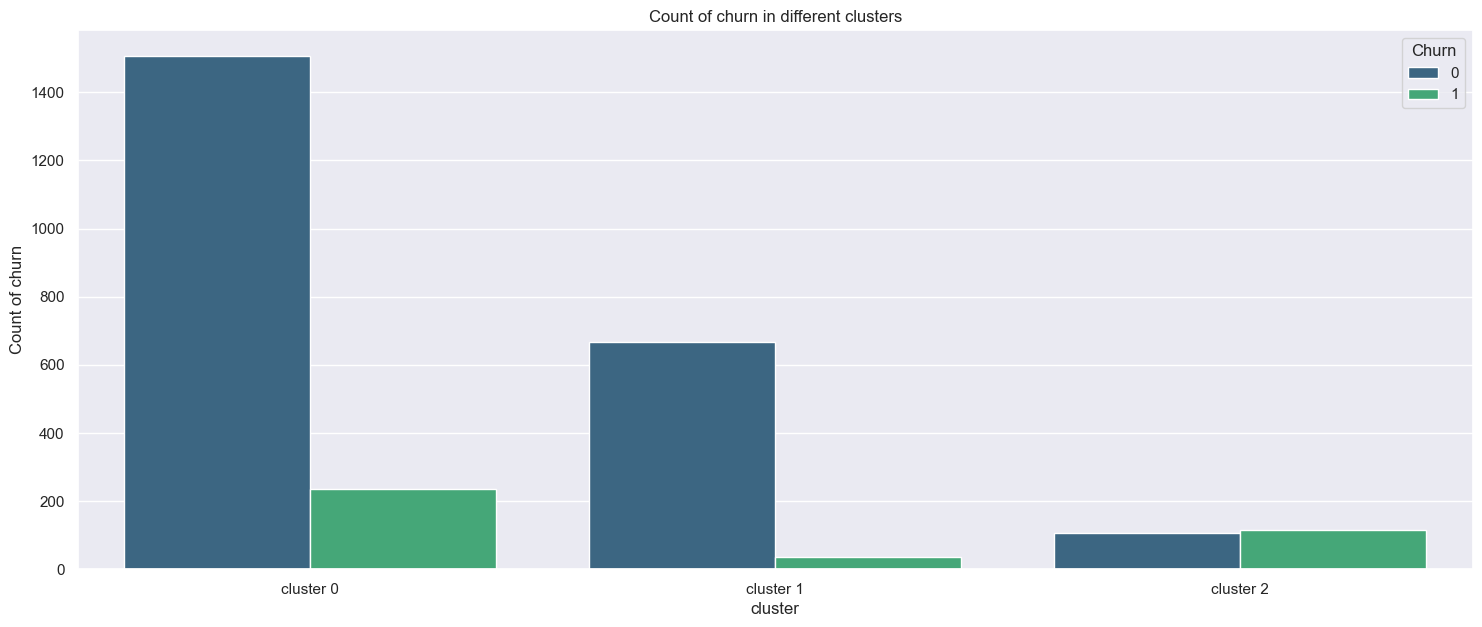

In [32]:
# find out cluster distribution with respect to churn
# visualise voice mail plan over clusters.
plt.figure()
pl = sns.countplot(x=df_c1["cluster"],hue=df_c1["Churn"], palette='viridis')
pl.set_title("Count of churn in different clusters")
pl.set_ylabel("Count of churn")
pl.set_xlabel("cluster")

# Get the x-axis tick labels
xlabels = ['cluster 0', 'cluster 1', 'cluster 2']

# Set the x-axis tick labels and align them to the center
ax = pl.axes
ax.set_xticklabels(xlabels, ha='center')

plt.show()

From the distribution of churn status in each cluster, we can notice cluster pattern below: 

- **Cluster 0** : <br>
    - more than half of the samples are in this cluster (1608 samples)
    - Almost all of the customers do not churn. 

- **Cluster 1**: <br>
    - the second largest cluster (730 samples)
    - Near 10% of the customers in this cluster churn their services. 

- **Cluster 2**: <br>
    - the smallest cluster (328 samples)
    - almost all customers in this cluster churn their services. 

**Categorical features analysis**

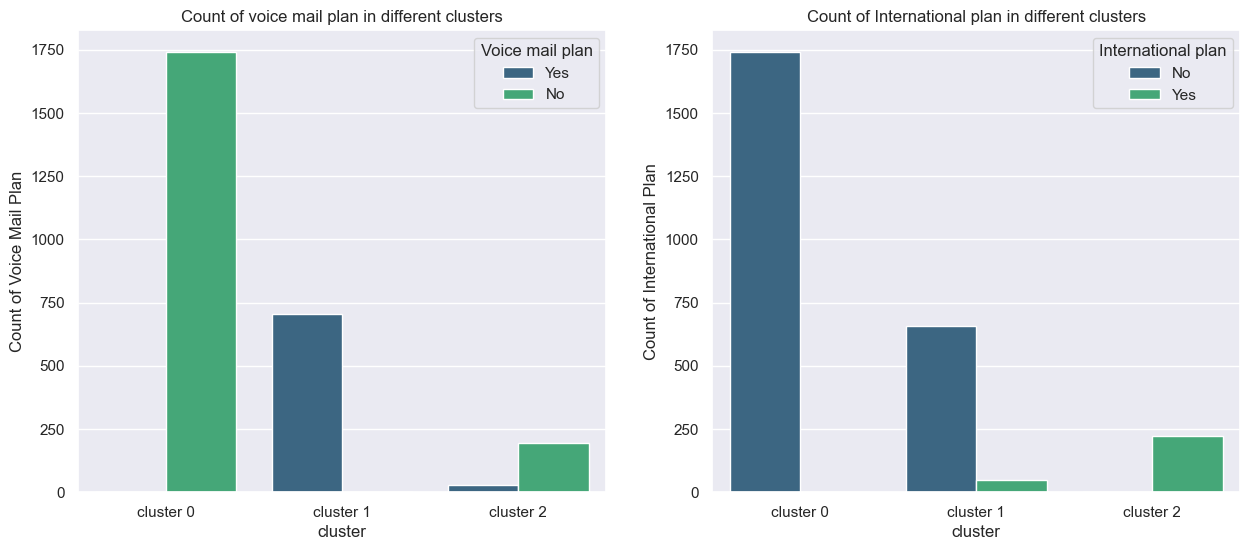

In [33]:
# visualise voice mail plan over clusters.
fig, ax = plt.subplots(1,2, figsize=(15,6))

pl = sns.countplot(x=df_c1["cluster"],hue=df_c1["Voice mail plan"], palette='viridis', ax=ax[0])
ax[0].set_title("Count of voice mail plan in different clusters")
ax[0].set_ylabel("Count of Voice Mail Plan")
ax[0].set_xlabel("cluster")
ax[0].set_xticklabels(xlabels, ha='center')

pl = sns.countplot(x=df_c1["cluster"],hue=df_c1["International plan"], palette='viridis', ax=ax[1])
ax[1].set_title("Count of International plan in different clusters")
ax[1].set_ylabel("Count of International Plan")
ax[1].set_xlabel("cluster")
ax[1].set_xticklabels(xlabels, ha='center')

plt.show()

In [34]:
# state
print('modal State for cluster 0:', df_c1[df_c1['cluster']==0].State.mode()[0])
print('modal State for cluster 1:', df_c1[df_c1['cluster']==1].State.mode()[0])
print('modal State for cluster 2:', df_c1[df_c1['cluster']==2].State.mode()[0])

modal State for cluster 0: WV
modal State for cluster 1: OH
modal State for cluster 2: IL


**Observations:**

- **Cluster 0** : <br>
    - All of them do not have voice mail plan.
    - Most of the customers are in the state of 'WV'. 

- **Cluster 1**: <br>
    - All of them have voice mail plan. 
    - A small portion of them have international plan. 
    - Most of the customers are in the state of 'WV'. 

- **Cluster 2**: <br>
    - All of them have voice mail plan.
    - A large portion of them have international plan. 
    - Most of the customers are in the state of 'MN'. 

<br>

**Discussion** <br>
From the observations, we can see that the clustering is largely dependent on the `Voice mail plan` feature as all customers from cluster 1 and 2 have voice mail plan but none of them in cluster 0 have it.  As for the `International plan`, we can notice that only a small portion of customers in cluster 1 subscribe to an international plan. Meanwhile, nearly half of the customers in cluster 2 hold an international plan. This observation is consistent with our common sense that people tend to cancel their international plan. Besides, most of the customers in cluster 0 and 1 (clusters that seldom churn) are located in the `state` of 'WV'. This is an interesting feature that can be further looked into in the future discussion. 

**Numerical features analysis**
<br>

As `Total intl charge` do not contribute to the prediction of `Churn`, it is not included in the analysis. 


In [35]:
num_c1 = df_c1.select_dtypes(np.number).drop('Total intl charge', axis=1)
num_c1

Number vmail messages  Total intl minutes  Total intl calls  \
0                        25                10.0                 3   
1                        26                13.7                 3   
2                         0                12.2                 5   
3                         0                 6.6                 7   
4                         0                10.1                 3   
...                     ...                 ...               ...   
2661                      0                11.8                 5   
2662                     36                 9.9                 6   
2663                      0                 9.6                 4   
2664                      0                14.1                 6   
2665                     25                13.7                 4   

      Customer service calls  Churn  unit fees local  unit fees intl  \
0                          1      0         0.170011        0.270000   
1                          1      0         0.169988        0.270073   
2                          0      0         0.170008        0.269672   
3                          2      0         0.170007        0.269697   
4                          3      0         0.170006        0.270297   
...                      ...    ...              ...             ...   
2661                       2      0         0.170007        0.270339   
2662                       2      0         0.169974        0.269697   
2663                       3      0         0.170013        0.269792   
2664                       2      0         0.170022        0.270213   
2665                       0      0         0.170009        0.270073   

      local_calls_total  local_minutes_total  local_charge_total  cluster  
0                   300                707.2               72.86        1  
1                   329                611.5               55.54        1  
2                   328                527.2               59.00        0  
3                   248                558.2               65.02        2  
4                   356                501.9               49.36        2  
...                 ...                  ...                 ...      ...  
2661                294                545.8               48.98        0  
2662                286                650.8               57.43        1  
2663                235                575.8               60.94        0  
2664                258                661.5               63.93        0  
2665                272                741.7               73.31        1  

[2666 rows x 11 columns]

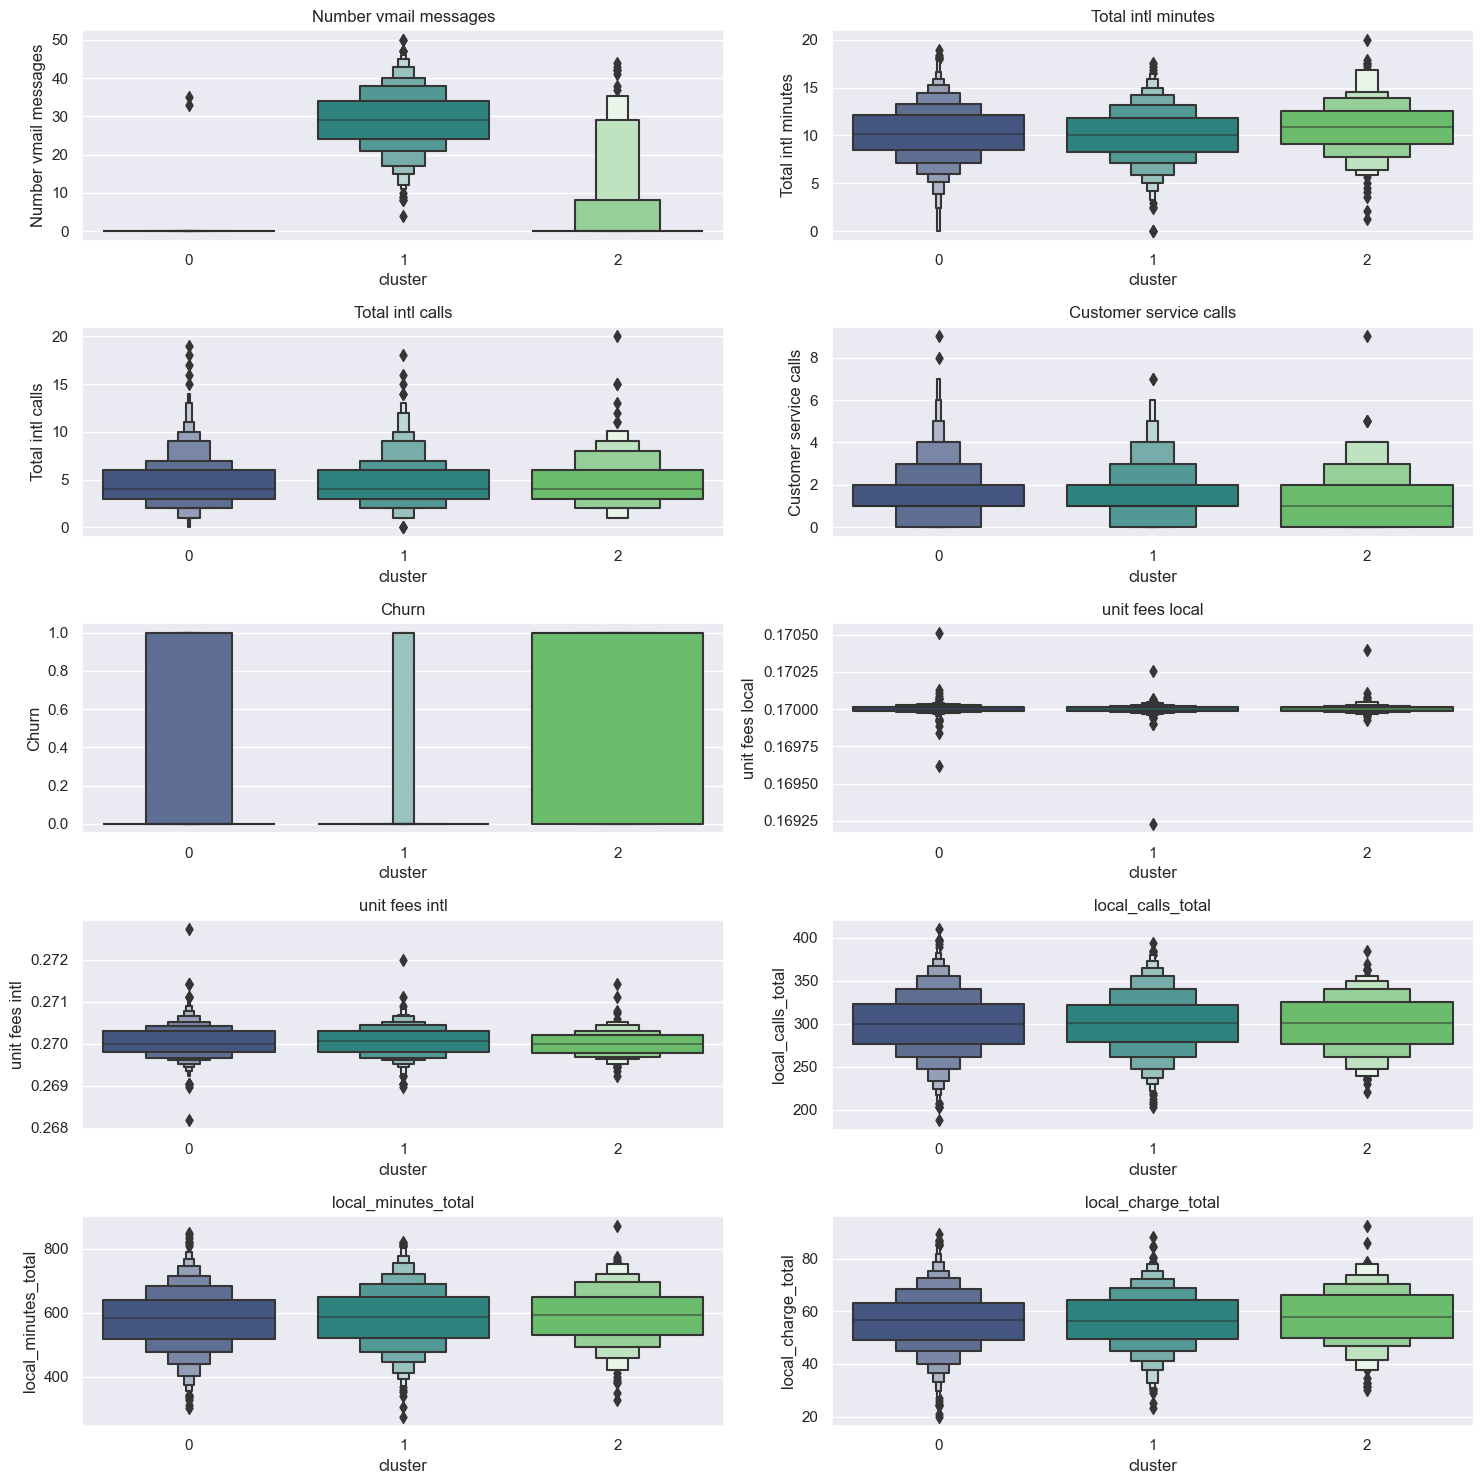

In [36]:
# Create a figure with 10 subplots, arranged in 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Flatten the subplots array so we can iterate over it easily
axes = axes.flatten()

# Iterate over the columns of the dataframe
for ax, col in zip(axes, num_c1.columns):
    sns.boxenplot(data=num_c1, x='cluster', y=col, ax=ax, palette = 'viridis')
    ax.set_title(col)

# Adjust the layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()

**Observations:**
For the numerical features, most features have very similar distributions in every cluster. To prevent cluttering, the observations in this section only focuses on the features with interesting difference between clusters. 
<br>

- **Cluster 0** : <br>
    -  similar `Total intl minutes` and `Total intl calls` with cluster 1
    - similar number of `Customer service calls` compared with cluster 1
    - similar `local_minutes_total` and `local_charge_total` with cluster 1

- **Cluster 1**: <br>
    - similar `Total intl minutes` and `Total intl calls` with cluster 0
    - similar number of `Customer service calls` compared with cluster 0
    - similar `local_minutes_total` and `local_charge_total` with cluster 0

- **Cluster 2**: <br>
    - slightly higher median of `Total intl minutes` compared with the other two clusters. Ironically, they have significantly fewer `Total intl calls` than the other two clusters. 
    - have a lot more `Customer service calls` compared with the other two clusters. 
    - significantly higher `local_minutes_total` and `local_charge_total` compared with cluster 0 and 1


#### conclusion


- **Cluster 0** : <br>
    - more than half of the samples are in this cluster (1608 samples)
    - Almost all of the customers do not churn. 
    - __All of them do not have voice mail plan.__
    - Most of the customers are in the state of 'WV'. 


- **Cluster 1**: <br>
    - the second largest cluster (730 samples)
    - Near 10% of the customers in this cluster churn their services. 
    - __All of them have voice mail plan.__ 
    - Most of the customers are in the state of 'WV'. 

- **Cluster 2**: <br>
    - the smallest cluster (328 samples)
    - almost all customers in this cluster churn their services. 
    - A large portion of them have international plan. 
    - Most of the customers are in the state of 'MN'.
    - slightly higher median of `Total intl minutes` compared with the other two clusters. Ironically, they have significantly fewer `Total intl calls` than the other two clusters. 
    - have a lot more `Customer service calls` compared with the other two clusters. 
    - significantly higher `local_minutes_total` and `local_charge_total` compared with cluster 0 and 1

<br>

**Discussion** <br>
Compared with customers from cluster 0 who do not churn at all, customers from cluster 1 are noticeably more likely to churn their services. While we notice that characteristics of customers in cluster 0 is almost the same with cluster 1, there is one single difference between the two clusters that might result in the difference: All of the customers in cluster 1 have a voice mail plan while all of the customers in cluster 0 do not. 

Meanwhile, we observe that most people who churn are in cluster 2, and customers from cluster 2 shows a great deal of differences in characteristics compared with the other two clusters. The most significant differences are: (1) they spend a lot more time on calls compared with the other two clusters, locally and internationally. (2) They deal with much more customer service calls compared with the other two. These differences might result in almost all customers in cluster 2 churning their services, with reasons to be further investigated. 



## Method 2: DBSCAN

As DBScan works in Euclidean space, categorical features cannot be used in this clustering model. In this case, `Gower distance` is deployed to resolve this issue. <br>

### Gower distance

Gower distance is a measure to find similarity between two rows of dataset consisting of mixed data (categorical and numerical). It works by combining composite distance measures for continuous and discrete variables with Manhattan distance and Dice distance respectively. By applying gower distance, we can compute the similarity or dissimilarity between two data points on the same metric. This allows further clustering to occur. <br>

Gower distance lies in the range of 0 and 1. The closer the distance is to 1, the larger the difference between two data points. The closer the distance is to 0, the more similar the two data points are. 

In [37]:
!pip install gower

<AxesSubplot: >

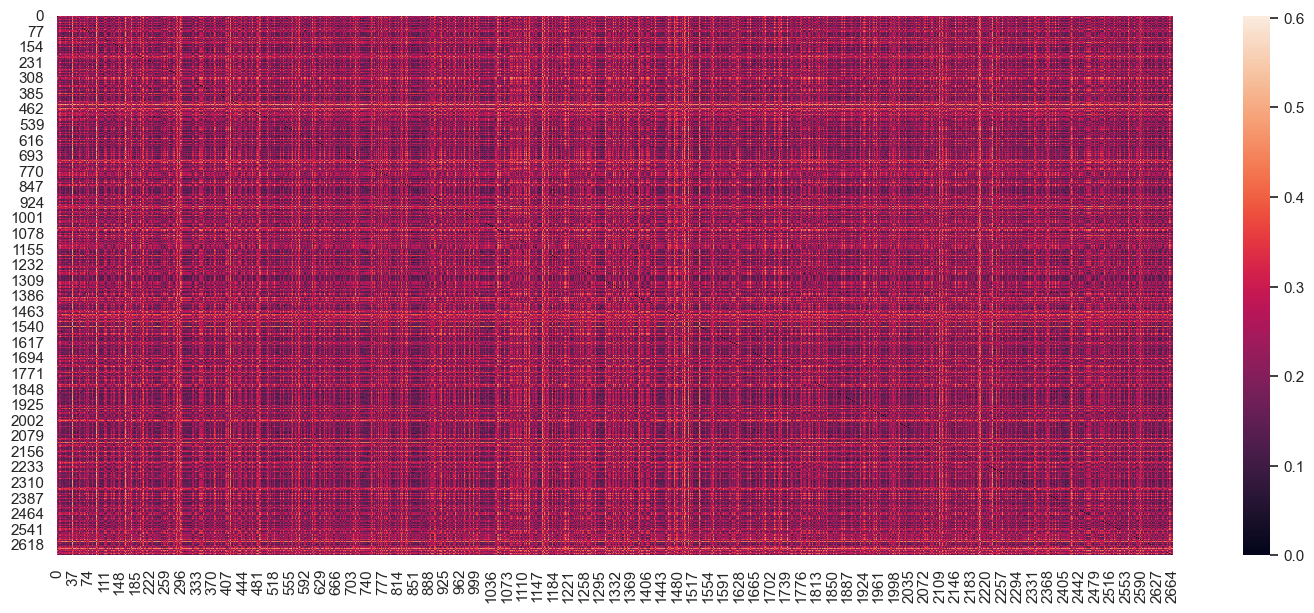

In [38]:
import gower

gower_matrix = gower.gower_matrix(df_scaled)
sns.heatmap(gower_matrix)

By visually inspecting the heatmap, we can observe that the dataset has a relatively small Gower distance from one another, meaning that they are similar to one another. 

### Clustering on distance matrix

The parameters for DBSCAN: `eps` and `min_samples` are hand-tuned to optimize two objectives:

1. maximise the silhoutte score
2. clusters are visualised to ensure that the clusters are interpretable.

In [39]:
# Configuring the parameters of the clustering algorithm

dbscan_df = df_scaled.copy()

# multiple tuning attempts are required for eps and min_sample

eps_val = 0.109
min_samples = 10

dbscan_cluster = DBSCAN(eps=eps_val, 
                        min_samples=min_samples, 
                        metric="precomputed") # gower distance is not yet been integrated in sklearn library

# Fitting the clustering algorithm
dbscan_cluster.fit(gower_matrix)

# Adding the results to a new column in the dataframe
dbscan_df["cluster"] = dbscan_cluster.labels_

# Compute silhouette score
silhouette_avg = silhouette_score(gower_matrix, dbscan_cluster.labels_)
print("For eps =", eps_val, ", min_samples =", min_samples, ", The average silhouette_score is :", silhouette_avg)

For eps = 0.109 , min_samples = 10 , The average silhouette_score is : 0.5122158


Explore the characteristics of each cluster

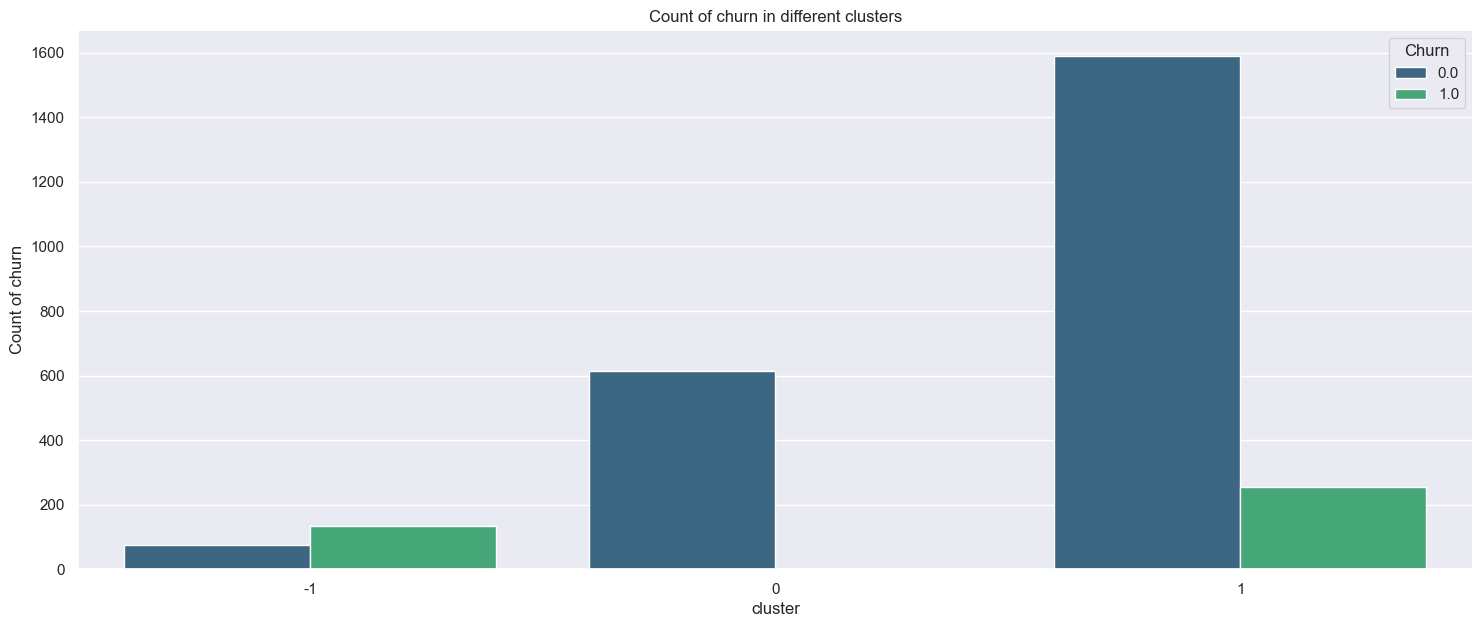

In [40]:
# find out cluster distribution with respect to churn
# visualise voice mail plan over clusters.
plt.figure()
pl = sns.countplot(x=dbscan_df["cluster"],hue=dbscan_df["Churn"], palette='viridis')
pl.set_title("Count of churn in different clusters")
pl.set_ylabel("Count of churn")
pl.set_xlabel("cluster")

# Set the x-axis tick labels and align them to the center
ax = pl.axes

plt.show()

From the distribution of churn status in each cluster, we can notice cluster pattern below: 

- **Cluster -1** : <br>
    - the smallest cluster (133 samples)
    - most of the customers in this cluster churn their services. 

    
- **Cluster 0**: <br>
    - the second largest cluster (613 samples)
    - All of the customers in this cluster do not churn.
    

- **Cluster 1**: <br>
    - more than half of the samples are in this cluster (1590 samples)
    - Almost all of the customers do not churn.

**Categorical features analysis**

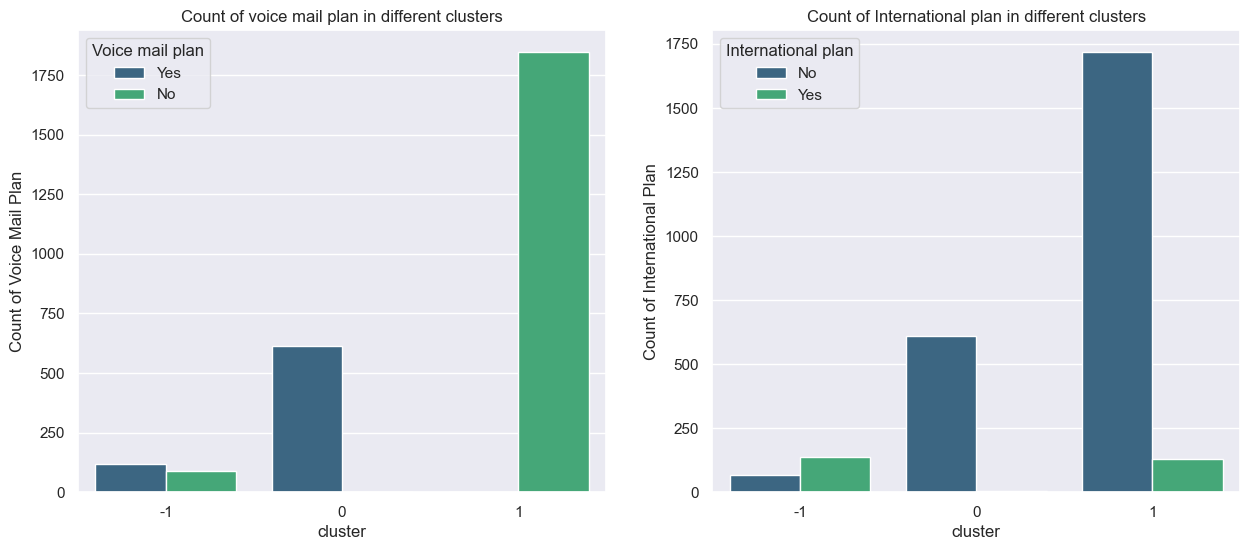

In [41]:
# visualise voice mail plan over clusters.
fig, ax = plt.subplots(1,2, figsize=(15,6))

pl = sns.countplot(x=dbscan_df["cluster"],hue=dbscan_df["Voice mail plan"], palette='viridis', ax=ax[0])
ax[0].set_title("Count of voice mail plan in different clusters")
ax[0].set_ylabel("Count of Voice Mail Plan")
ax[0].set_xlabel("cluster")

pl = sns.countplot(x=dbscan_df["cluster"],hue=dbscan_df["International plan"], palette='viridis', ax=ax[1])
ax[1].set_title("Count of International plan in different clusters")
ax[1].set_ylabel("Count of International Plan")
ax[1].set_xlabel("cluster")

plt.show()

In [42]:
# state
print('modal State for cluster -1:', dbscan_df[dbscan_df['cluster']==-1].State.mode()[0])
print('modal State for cluster 0:', dbscan_df[dbscan_df['cluster']==0].State.mode()[0])
print('modal State for cluster 1:', dbscan_df[dbscan_df['cluster']==1].State.mode()[0])

modal State for cluster -1: MS
modal State for cluster 0: WV
modal State for cluster 1: WV


**Observations:**

- **Cluster -1** : <br>
    - All of them have voice mail plan.
    - More than 50% of them have international plan. 
    - Most of the customers are in the state of 'MS'. 

- **Cluster 0**: <br>
    - All of them have voice mail plan. 
    - Only 3 of them have international plan. 
    - Most of the customers are in the state of 'WV'. 

- **Cluster 1**: <br>
    - All of them do not have voice mail plan.
    - A small portion of them have international plan. 
    - Most of the customers are in the state of 'WV'. 

<br>

**Discussion** <br>
From the observations, we can see that the clustering is largely dependent on the `Voice mail plan` feature as all customers from cluster -1 and 0 have voice mail plan but none of them in cluster 1 have it.  As for the `International plan`, we can notice that only a small portion of customers in cluster 0 and cluster 1 subscribe to an international plan. Meanwhile, more than half of the customers in cluster -1 hold an international plan. This observation is consistent with our common sense that people tend to cancel their international plan. Besides, most of the customers in cluster 0 and 1 (clusters that seldom churn) are located in the `state` of 'WV'. This is an interesting feature that can be further looked into in the futurediscussion. 

**Numerical features analysis**
<br>

As `Total intl charge` do not contribute to the prediction of `Churn`, it is not included in the analysis. 


In [43]:
num_c2 = dbscan_df.select_dtypes(np.number).drop('Total intl charge', axis=1)
num_c2

Number vmail messages  Total intl minutes  Total intl calls  \
0                      0.50               0.500              0.15   
1                      0.52               0.685              0.15   
2                      0.00               0.610              0.25   
3                      0.00               0.330              0.35   
4                      0.00               0.505              0.15   
...                     ...                 ...               ...   
2661                   0.00               0.590              0.25   
2662                   0.72               0.495              0.30   
2663                   0.00               0.480              0.20   
2664                   0.00               0.705              0.30   
2665                   0.50               0.685              0.20   

      Customer service calls  Churn  unit fees local  unit fees intl  \
0                   0.111111    0.0         0.608827        0.400000   
1                   0.111111    0.0         0.590347        0.416058   
2                   0.000000    0.0         0.606409        0.327869   
3                   0.222222    0.0         0.605210        0.333333   
4                   0.333333    0.0         0.604679        0.465347   
...                      ...    ...              ...             ...   
2661                0.222222    0.0         0.605791        0.474576   
2662                0.222222    0.0         0.580026        0.333333   
2663                0.333333    0.0         0.610125        0.354167   
2664                0.222222    0.0         0.617257        0.446809   
2665                0.000000    0.0         0.606655        0.416058   

      local_calls_total  local_minutes_total  local_charge_total  cluster  
0              0.504505             0.724225            0.728575        0  
1              0.635135             0.563789            0.489942        0  
2              0.630631             0.422464            0.537614        1  
3              0.270270             0.474434            0.620557       -1  
4              0.756757             0.380050            0.404795        1  
...                 ...                  ...                 ...      ...  
2661           0.477477             0.453646            0.399559        1  
2662           0.441441             0.629673            0.515982        0  
2663           0.211712             0.503940            0.564343        1  
2664           0.315315             0.647611            0.605539        1  
2665           0.378378             0.782062            0.734775        0  

[2666 rows x 11 columns]

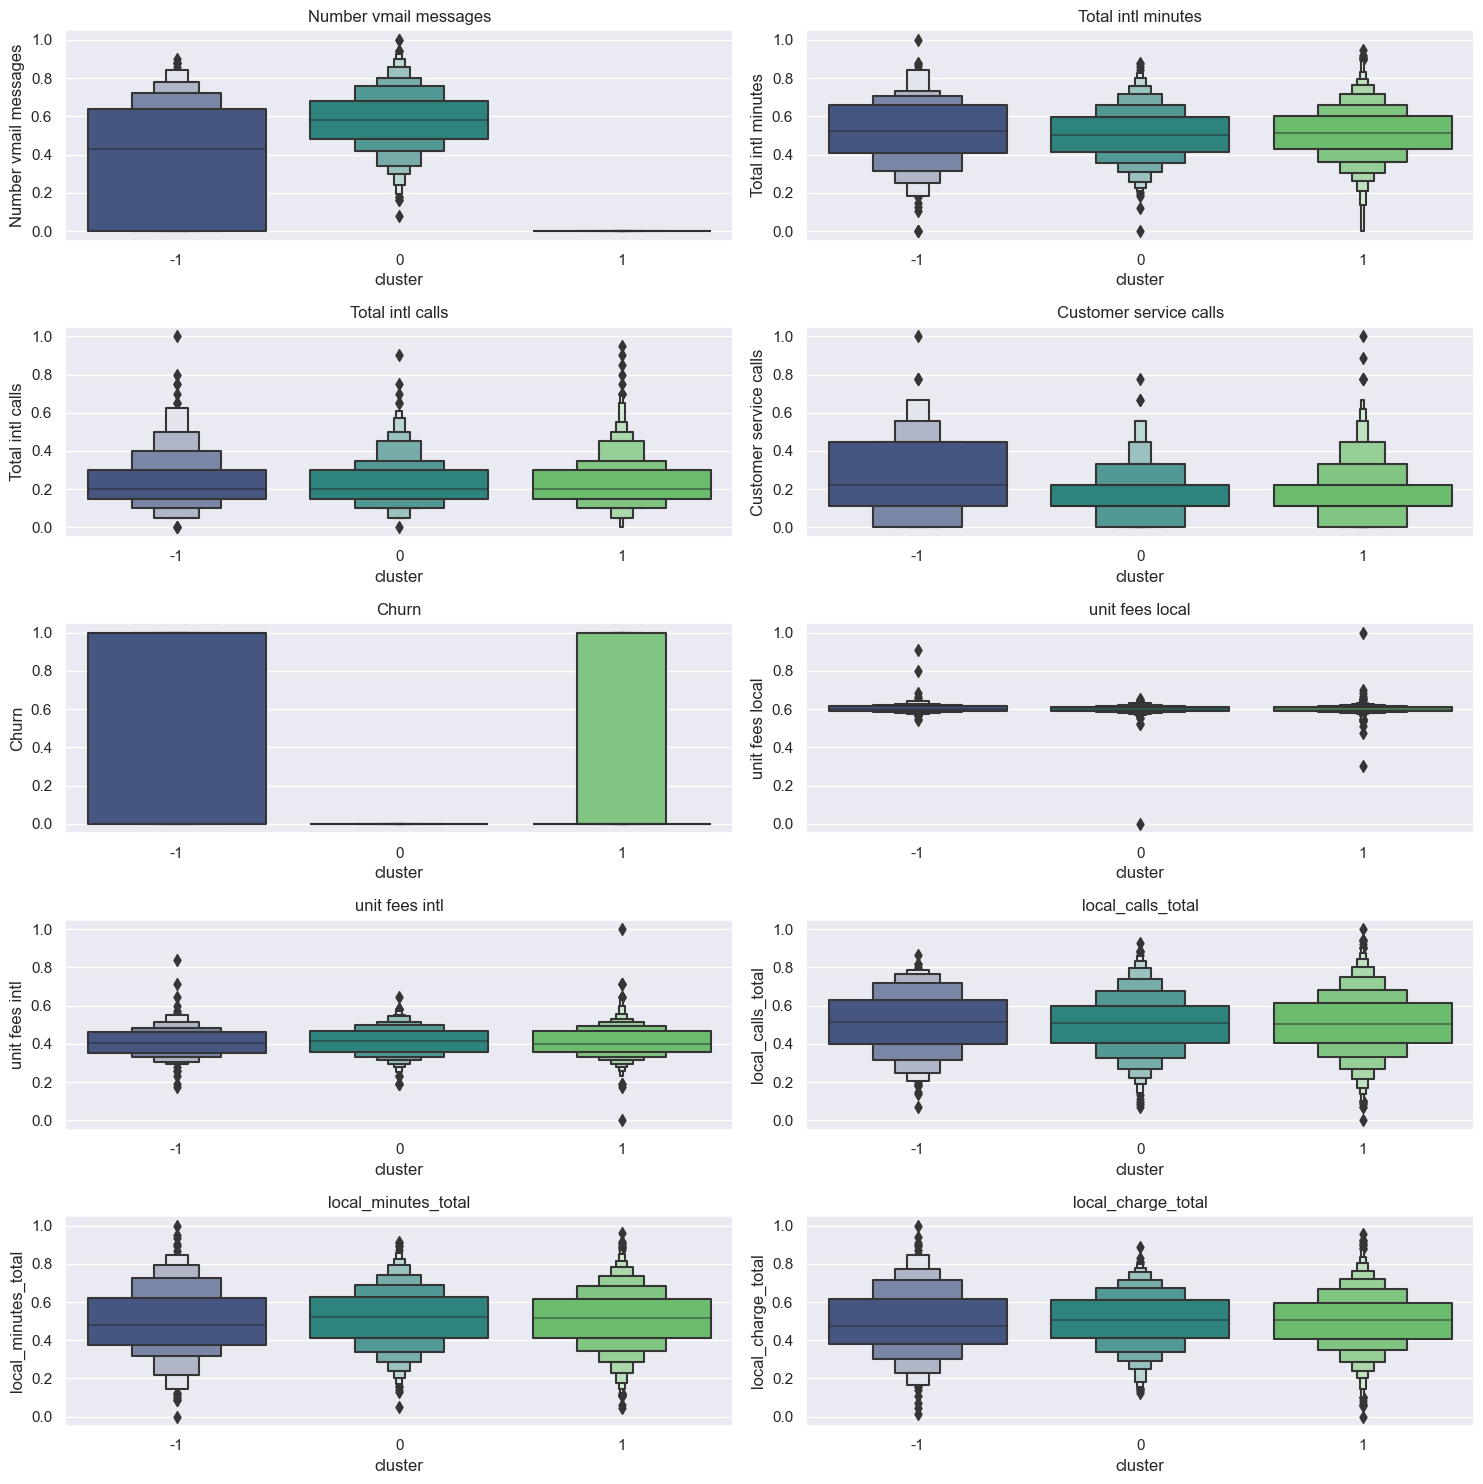

In [44]:
# Create a figure with 10 subplots, arranged in 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Flatten the subplots array so we can iterate over it easily
axes = axes.flatten()

# Iterate over the columns of the dataframe
for ax, col in zip(axes, num_c1.columns):
    sns.boxenplot(data=num_c2, x='cluster', y=col, ax=ax, palette = 'viridis')
    ax.set_title(col)

# Adjust the layout of the subplots
plt.tight_layout()

# Show the figure
plt.show()

**Observations:**
For the numerical features, most features have very similar distributions in every cluster. To prevent cluttering, the observations in this section only focuses on the features with interesting difference between clusters. 
<br>

- **Cluster -1** : <br>
    - slightly higher median of `Total intl minutes` compared with the other two clusters. Ironically, they have significantly fewer `Total intl calls` than the other two clusters. 
    - have a lot more `Customer service calls` compared with the other two clusters. 


- **Cluster 0**: <br>
    - similar `Total intl minutes` and `Total intl calls` with cluster 1
    - similar number of `Customer service calls` compared with cluster 1
    - similar `local_minutes_total` with cluster 1
    - slightly lower median of `local_charge_total`compared with cluster -1 and 1
    

- **Cluster 1**: <br>
    - similar `Total intl minutes` and `Total intl calls` with cluster 0
    - similar number of `Customer service calls` compared with cluster 0
    - similar `local_minutes_total` with cluster 0
    - similar `local_charge_total`compared with cluster -1


#### conclusion


- **Cluster -1** : <br>
    - more than half of the samples have international plan.
    - Most of the customers churn their services.
    - the smallest cluster (133 samples).
    - __All of them have voice mail plan.__
    - Most of the customers are in the state of 'MS'. 
    - slightly higher median of `Total intl minutes` compared with the other two clusters. Ironically, they have significantly fewer `Total intl calls` than the other two clusters. 
    - have a lot more `Customer service calls` compared with the other two clusters. 


- **Cluster 0**: <br>
    - the second largest cluster (613 samples)
    - All of the customers in this cluster do not churn their services. 
    - Only 3 of them have international plan.
    - __All of them have voice mail plan.__ 
    - Most of the customers are in the state of 'WV'. 
    

- **Cluster 1**: <br>
    - the largest cluster (1590 samples)
    - almost all customers in this cluster do not churn their services. 
    - A small portion of them have international plan. 
    - __All of them have voice mail plan.__ 
    - Most of the customers are in the state of 'WV'.
   

<br>

**Discussion** <br>
Compared with customers from cluster 0 who do not churn at all, customers from cluster 1 are noticeably more likely to churn their services. While we notice that characteristics of customers in cluster 0 is almost the same with cluster 1, there is one single difference between the two clusters that might result in the difference: All of the customers in cluster 0 have a voice mail plan while all of the customers in cluster 1 do not. 

Meanwhile, we observe that most people who churn are in cluster -1, and customers from cluster -1 shows a great deal of differences in characteristics compared with the other two clusters. The most significant differences are: (1) they spend a lot more time on calls compared with the other two clusters, locally and internationally. (2) They deal with much more customer service calls compared with the other two. These differences might result in almost all customers in cluster -1 churning their services, with reasons to be further investigated. 

